In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
        

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords


pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=7)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
from ArtificialHandwritting import ArtificialHandwritting
artificial_data = ArtificialHandwritting(batch_size, "./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png


In [0]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

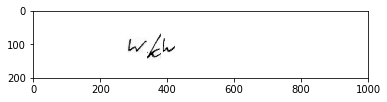

torch.Size([100, 200, 1000])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])
        h = h.squeeze(2)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:

        
class FCDecoder(nn.Module):
  def __init__(self):
    super(FCDecoder, self).__init__()
    encoded_width = 122
    encoded_height = 64
    encoded_size = encoded_width*encoded_height
    symbols_count = len(train_set.codes)
    from math import floor
    self.fc = FullyConnectedX([encoded_size, floor(encoded_size*0.7)], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.LeakyReLU(0.2))
    self.fc2 = FullyConnectedX([floor(encoded_size*0.7), floor(encoded_size*0.3), symbols_count], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
    self.bn = nn.BatchNorm1d(floor(encoded_size*0.7))
    
  def forward(self, x):
    x = self.fc(x)
    x = self.bn(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x

encoder_fc = FCDecoder().to(device)
  
  
cnn_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
fc_optimizer = optim.Adam(encoder_fc.parameters(), lr=1e-4, weight_decay=0.00005)
criterion = nn.NLLLoss()
randx = 900




In [0]:
recognition_result = torch.LongTensor(batch_size, 1).to(device)

for i in range(0, 2000):
    data, target = artificial_data.make_random_batch(1, randx)
    data = data.unsqueeze(1).to(device)
    target = target.to(device)
    cnn_optimizer.zero_grad()
    fc_optimizer.zero_grad()
    enc = encoder(data)
    enc = enc.flatten(start_dim=1)
    symb = encoder_fc(enc)
    loss = criterion(symb, target[:, 0])
    if i % 50 == 0:
      recognition_result[:,0] = symb.topk(1, dim=1)[1].flatten().detach()
      for i in range(0, 5):
        t = test_set.decode_word(target[i,:])
        r = test_set.decode_word(recognition_result[i,:])
        print(t + "->" + r)
      print(loss.item())
    loss.backward()
    cnn_optimizer.step()
    fc_optimizer.step()

f->q
q->q
a->a
r->r
b->b
2.6310861110687256
h->h
m->m
h->u
e->e
b->b
2.622636079788208
g->g
z->z
v->y
k->k
l->t
2.6252410411834717
m->w
m->m
w->h
k->h
z->z
2.629223108291626
h->h
q->q
w->h
f->f
y->w
2.6085665225982666
h->u
j->j
c->e
l->l
b->b
2.6162166595458984
g->g
v->v
g->g
c->e
d->d
2.5939812660217285
d->d
x->s
p->p
h->h
z->z
2.598590612411499
g->d
d->d
k->h
k->h
o->o
2.6026787757873535
w->w
q->d
r->r
c->e
u->h
2.5790352821350098
p->g
h->h
q->q
z->z
v->v
2.597132921218872
z->z
f->l
h->h
z->z
h->h
2.553447961807251
t->l
p->p
p->p
z->z
v->v
2.541186571121216
e->e
b->b
x->x
a->a
k->h
2.5517826080322266
c->c
a->a
w->w
p->p
k->h
2.579864501953125
e->e
g->g
o->o
h->h
x->x
2.5378713607788086
i->i
i->i
l->l
j->j
i->i
2.5448856353759766
k->k
n->x
q->q
o->o
c->c
2.5445191860198975
i->i
f->f
g->g
h->h
r->s
2.540536403656006
c->e
w->w
w->w
w->h
v->y
2.5518453121185303


In [0]:
def save_cnn(file_name):
  state_dict = {
        "encoder": encoder.state_dict()
      }
  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)
save_cnn("/gdrive/My Drive/cnn.tar")

Network saved: /gdrive/My Drive/cnn.tar


In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            
            self.attention_weights = self.attention(attention_inp)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        #x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size, prob, randx):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:

      if random() <= prob:
        if (prob >= 1) and (batch_idx > 100):
          break
        l = 1 + floor(max_size*random())
        data, target = artificial_data.make_random_batch(l, randx)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    
      loss = 0
      enc = encoder(data)
      s = enc
      s = s.detach()

      old_symbol[:, 0] = START
      for i in range(0, target.shape[1] + 1):
        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = recognition_result[:, i]#target[:, i]
        k = 1
        if i == target.shape[1]:
          target_symbol = stop_symbol[:, 0]
          k = 1.5
        else:
          target_symbol = target[:, i]  
        loss += k*criterion(dec, target_symbol)
      c_loss += loss.item()/(target.shape[1] + 1)
      test_loss += loss.item()/(target.shape[1] + 1)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Layers import *

# Based on: https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class HTRDiscriminator(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, input_length, symbs_cnt):
        super(HTRDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        #self.hidden_cells = 256
        #self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 2
        
        self.input_size = 8576
        self.gru_input_size = self.input_size#512*2
        self.enc = FullyConnectedX([self.input_size, floor(self.input_size*0.7), self.gru_input_size], activation_fn=nn.ReLU())
        self.batchnorm = nn.BatchNorm1d(self.gru_input_size)
        self.gru = nn.GRU(self.gru_input_size, hidden_size, self.rnn_layers)
        self.gru_out = hidden_size*input_length
        self.fc = FullyConnectedX([self.gru_out, floor(self.gru_out*0.7), floor(self.gru_out*0.3), 1], activation_fn=nn.ReLU())

    def makeFeatures(self, hidden, hidden_states, dec_inputs, dec_outputs):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        #print(full_input.shape)
        output = full_input#self.enc(full_input)
        output = output.unsqueeze(0)
        #print(output.shape)
        output, hidden = self.gru(output, hidden)
        #print(output.shape)
        return output, hidden
        #output= output.squeeze(0)
        #out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
#         loss = F.binary_cross_entropy_with_logits(out, targets)
#         return loss, hidden
  
    def makeDecision(self, features):
      z = torch.zeros(self.input_length - len(features), batch_size, self.hidden_size).to(device)
      features.append(z)
      x = torch.cat(features, dim=0)
      x = x.permute(1, 0, 2)
      x = x.flatten(start_dim=1)
      #print(x.shape)
      x = self.fc(x)
      #print(x.shape)
      #print(x)
      return x

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, self.batch_size, self.hidden_size)
      
    def makeOutput(self):
        return torch.zeros(self.batch_size, self.gru_out)
      
      
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  discr_features = []
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      feats, discriminator_hidden = discriminator.makeFeatures(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach())
    else:
      feats, discriminator_hidden = discriminator.makeFeatures(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs)
    if i != 0:
      discr_features.append(feats)
#     if i != 0:
#       discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    loss += criterion(dec, target_symbol)*k
 
  discriminator_decision = discriminator.makeDecision(discr_features)
  #print("---------")
  #print(discriminator_decision[0:10])
  #print(discriminator_target[0:10])
  discriminator_loss = F.binary_cross_entropy_with_logits(discriminator_decision, discriminator_target)

  #discriminator_loss /= target.shape[1] + 1
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += k*criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:


criterion = nn.CrossEntropyLoss()
from random import random

def train(epoch, max_size, apply_professor, prob, randx, detach):
  print("Training epoch " + str(epoch) + "...")
  freq = 30
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  train_loss = 0
  discr_applied = 0
  while True:
    if random() <= prob:
      if (prob >= 1) and (batch_idx > 400):
        break    
      l = 1 + floor(max_size*random())
      data, target = artificial_data.make_random_batch(l, randx)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    with torch.no_grad():
      enc = encoder(data)
      s = enc
      s = s.unsqueeze(0)
      if detach:
        s = s.detach()
    discr_loss = 1
    if apply_professor:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      dl.backward()
      discriminator_optimizer.step()
    D_loss_curr = None
    batch_loss = None  
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    if apply_professor and (discr_loss < 0.2) and (discr_loss > 0.01):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      D_loss_curr = discriminator_loss.item()
      discr_applied += 1
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()
    c_loss += batch_loss/(target.shape[1] + 1)
    train_loss += batch_loss/(target.shape[1] + 1)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    
    if False:#D_loss_curr is not None:
      _, _, D_loss_new = apply_discriminator(s, target, True, False, batch_zeros)
      print("old/new: %f / %f Batch %f" %(D_loss_curr, D_loss_new, batch_loss))
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/unif v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
# def save_cnn(file_name):
#   state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict()
#       }
#   torch.save(state_dict, file_name)
#   print("Network saved: %s" %file_name)

# for i in range(0, 100):
#   save_cnn("/gdrive/My Drive/cnn.tar")
#   max_size =1
#   prob = 1
#   randx = 20
#   train(i, max_size, False, prob, randx, False)
#   test(max_size, prob, randx)


In [0]:

def restore_cnn(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
  encoder_optimizer.load_state_dict(state["encoder_optimizer"])
restore_cnn("/gdrive/My Drive/cnn.tar")

Training epoch 0...
  Batch: 30 Loss: 4.97653529908922
  Batch: 60 Loss: 3.2132151868608263
  Batch: 90 Loss: 3.0330934842427575
  Batch: 120 Loss: 2.7529314756393433
  Batch: 150 Loss: 2.704956316947937
  Batch: 180 Loss: 2.6538182497024536
  Batch: 210 Loss: 2.5765725109312267
  Batch: 240 Loss: 2.5849764664967854
  Batch: 270 Loss: 2.5163373602761165
  Batch: 300 Loss: 2.426769814226362
  Batch: 330 Loss: 2.3140591290262007
  Batch: 360 Loss: 2.354105260637071
  Batch: 390 Loss: 2.3335580905278523
Train loss: 2.783628
Discr applied 0 times.
Testing...
100


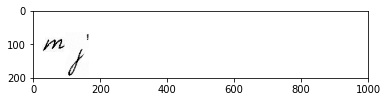

  'mj' -> 'nb<STOP>'


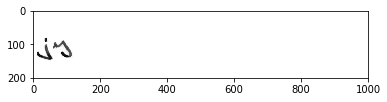

  'jy' -> 'x<STOP><STOP>'


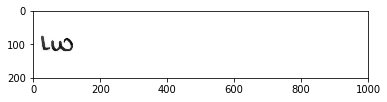

  'lw' -> 'x<STOP><STOP>'
  Batch: 20 Loss: 2.42224902510643
100


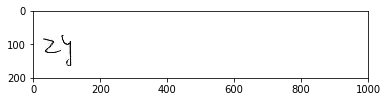

  'zy' -> 'n<STOP><STOP>'


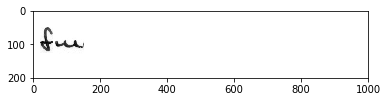

  'fm' -> 'z<STOP><STOP>'


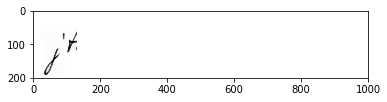

  'jt' -> 'ug<STOP>'
  Batch: 40 Loss: 2.2541843573252356
100


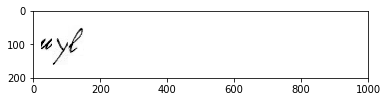

  'uyl' -> 'w<STOP><STOP><STOP>'


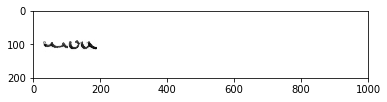

  'mvu' -> 'wg<STOP><STOP>'


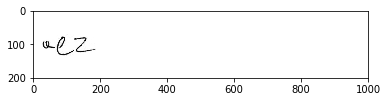

  'aez' -> 'uz<STOP><STOP>'
  Batch: 60 Loss: 2.20845414797465
100


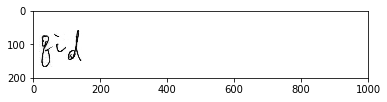

  'qid' -> 'zg<STOP><STOP>'


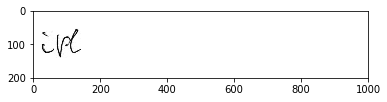

  'ipl' -> 'ze<STOP><STOP>'


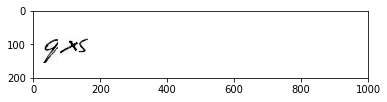

  'qxs' -> 'xn<STOP><STOP>'
  Batch: 80 Loss: 2.21413333217303
100


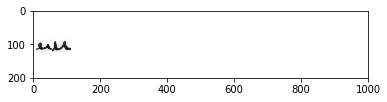

  'nu' -> 'z<STOP><STOP>'


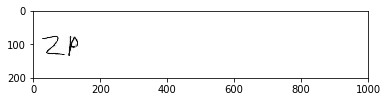

  'zp' -> 'zg<STOP>'


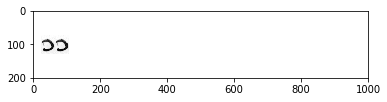

  'ss' -> 'd<STOP><STOP>'
  Batch: 100 Loss: 2.4205894768238063
Test loss: 2.281111
Training epoch 1...
  Batch: 30 Loss: 2.383307076825036
  Batch: 60 Loss: 2.250805066691505
  Batch: 90 Loss: 2.2727309690581428
  Batch: 120 Loss: 2.383519407113393
  Batch: 150 Loss: 2.3551794356769977
  Batch: 180 Loss: 2.0734119799402024
  Batch: 210 Loss: 2.169013346566094
  Batch: 240 Loss: 2.260749285750919
  Batch: 270 Loss: 2.3292066481378346
  Batch: 300 Loss: 2.1359299778938294
  Batch: 330 Loss: 2.13178901804818
  Batch: 360 Loss: 2.1707275562816193
  Batch: 390 Loss: 2.1327625022994146
Train loss: 2.232520
Discr applied 0 times.
Testing...
100


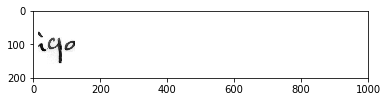

  'iqo' -> 'm<STOP><STOP><STOP>'


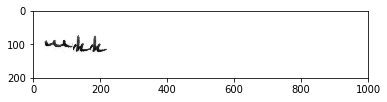

  'mkk' -> 'mwh<STOP>'


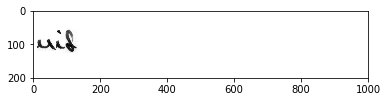

  'uif' -> 'dd<STOP><STOP>'
  Batch: 20 Loss: 2.5430428028106693
100


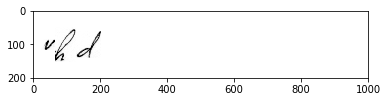

  'vhd' -> 'mwz<STOP>'


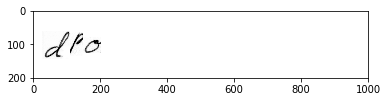

  'dpo' -> 'mww<STOP>'


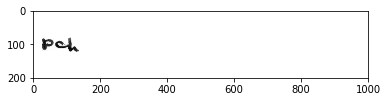

  'poh' -> 'wh<STOP><STOP>'
  Batch: 40 Loss: 2.2150999089082086
100


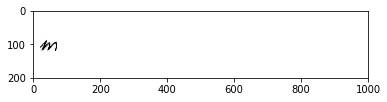

  'm' -> 'l<STOP>'


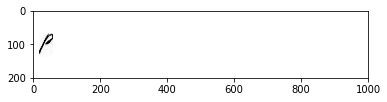

  'p' -> 'l<STOP>'


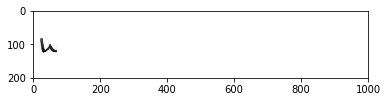

  'h' -> 'h<STOP>'
  Batch: 60 Loss: 2.2678570171197254
100


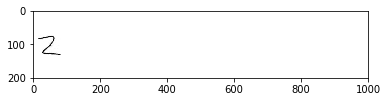

  'z' -> 'q<STOP>'


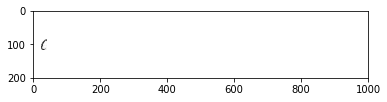

  'c' -> 'j<STOP>'


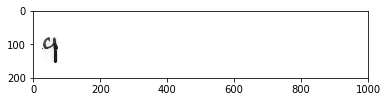

  'q' -> 'l<STOP>'
  Batch: 80 Loss: 2.2203045090039573
100


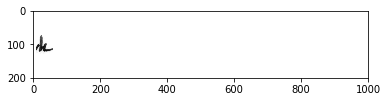

  'k' -> 'l<STOP>'


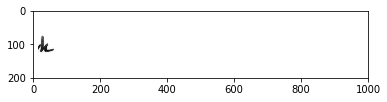

  'k' -> 'q<STOP>'


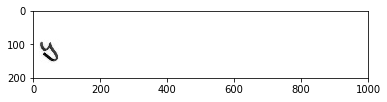

  'y' -> 'q<STOP>'
  Batch: 100 Loss: 2.267514928181966
Test loss: 2.279964
Training epoch 2...
  Batch: 30 Loss: 2.3076366212632924
  Batch: 60 Loss: 2.218924131658342
  Batch: 90 Loss: 2.0901933577325607
  Batch: 120 Loss: 2.0658506870269777
  Batch: 150 Loss: 2.2146456784672206
  Batch: 180 Loss: 2.1058620254198703
  Batch: 210 Loss: 2.170589560932583
  Batch: 240 Loss: 2.177891533904605
  Batch: 270 Loss: 2.238420489099291
  Batch: 300 Loss: 2.0368542061911685
  Batch: 330 Loss: 2.043136835098267
  Batch: 360 Loss: 2.259386157989502
  Batch: 390 Loss: 2.100627190536923
Train loss: 2.156324
Discr applied 0 times.
Testing...
100


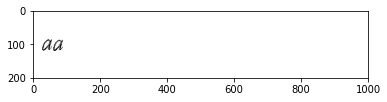

  'aa' -> 'lv<STOP>'


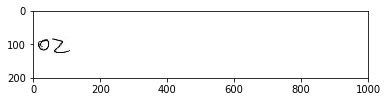

  'oz' -> 'w<STOP><STOP>'


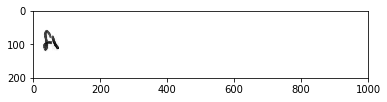

  'fl' -> 'v<STOP><STOP>'
  Batch: 20 Loss: 2.571800074974696
100


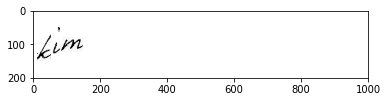

  'kim' -> 'ww<STOP><STOP>'


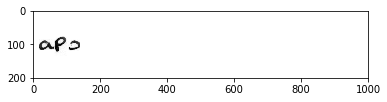

  'aps' -> 'wp<STOP><STOP>'


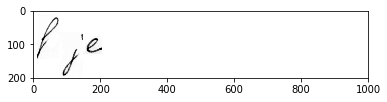

  'fje' -> 'ww<STOP><STOP>'
  Batch: 40 Loss: 2.186381326119105
100


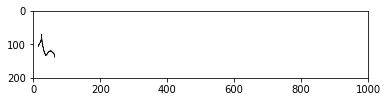

  'h' -> 'l<STOP>'


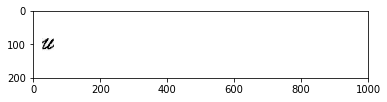

  'u' -> 'l<STOP>'


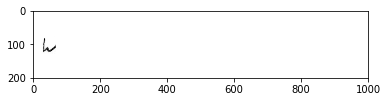

  'w' -> 'l<STOP>'
  Batch: 60 Loss: 2.344065403938293
100


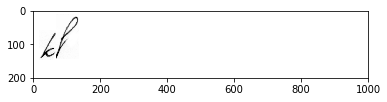

  'kf' -> 'wq<STOP>'


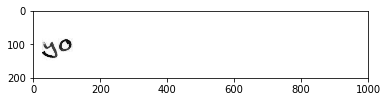

  'yo' -> 'yv<STOP>'


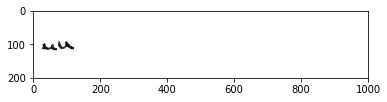

  'nu' -> 'wc<STOP>'
  Batch: 80 Loss: 2.310318676630656
100


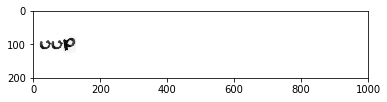

  'vvp' -> 'wt<STOP><STOP>'


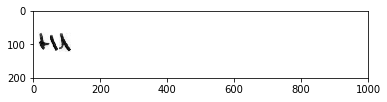

  'tll' -> 'm<STOP><STOP><STOP>'


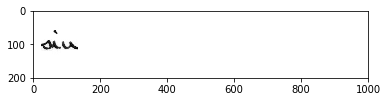

  'siu' -> 'wt<STOP><STOP>'
  Batch: 100 Loss: 2.314284416039785
Test loss: 2.322148
Training epoch 3...
  Batch: 30 Loss: 2.223641226026747
  Batch: 60 Loss: 2.2624649458461334
  Batch: 90 Loss: 2.094194851981269
  Batch: 120 Loss: 2.198712123764886
  Batch: 150 Loss: 2.1118998593754243
  Batch: 180 Loss: 2.175205502245161
  Batch: 210 Loss: 2.1530879497528077
  Batch: 240 Loss: 2.1814854847060308
  Batch: 270 Loss: 2.141503710216946
  Batch: 300 Loss: 2.134426849418216
  Batch: 330 Loss: 2.1081124835544163
  Batch: 360 Loss: 2.2017358620961507
  Batch: 390 Loss: 2.1548983335494993
Train loss: 2.152358
Discr applied 0 times.
Testing...
100


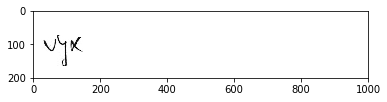

  'vyx' -> 'vy<STOP><STOP>'


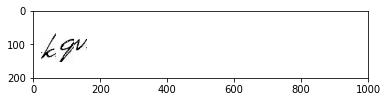

  'kqv' -> 'mn<STOP><STOP>'


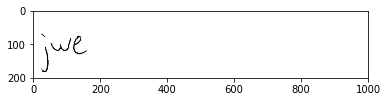

  'jwe' -> 'my<STOP><STOP>'
  Batch: 20 Loss: 2.5993945280710853
100


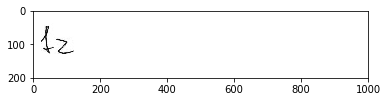

  'fz' -> 'yt<STOP>'


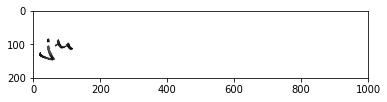

  'jh' -> 'yk<STOP>'


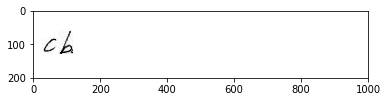

  'cb' -> 'ys<STOP>'
  Batch: 40 Loss: 2.3015788078308104
100


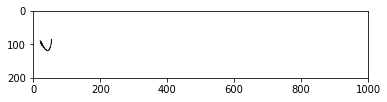

  'v' -> 't<STOP>'


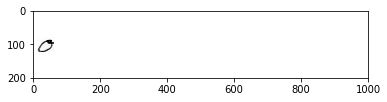

  'o' -> 't<STOP>'


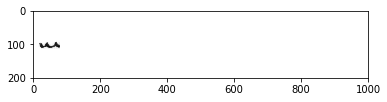

  'm' -> 't<STOP>'
  Batch: 60 Loss: 2.335416716337204
100


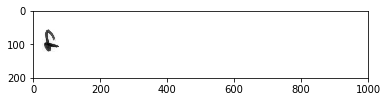

  'f' -> 't<STOP>'


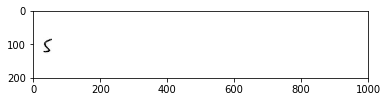

  's' -> 't<STOP>'


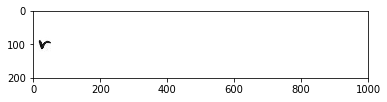

  'r' -> 't<STOP>'
  Batch: 80 Loss: 2.3443487167358397
100


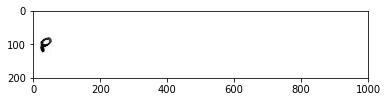

  'p' -> 'l<STOP>'


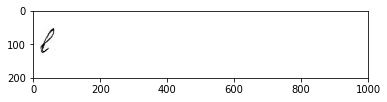

  'l' -> 't<STOP>'


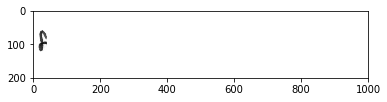

  'f' -> 't<STOP>'
  Batch: 100 Loss: 2.4321988264719647
Test loss: 2.378800
Training epoch 4...
  Batch: 30 Loss: 2.1210894213782416
  Batch: 60 Loss: 2.105458255608877
  Batch: 90 Loss: 2.171759206718869
  Batch: 120 Loss: 2.1300695723957483
  Batch: 150 Loss: 2.2268632332483933
  Batch: 180 Loss: 1.9992473456594675
  Batch: 210 Loss: 2.0167729443973963
  Batch: 240 Loss: 2.023434109157986
  Batch: 270 Loss: 2.0006929437319436
  Batch: 300 Loss: 2.0645968238512675
  Batch: 330 Loss: 2.122291546397739
  Batch: 360 Loss: 2.1457951174841985
  Batch: 390 Loss: 2.0957240170902676
Train loss: 2.094168
Discr applied 0 times.
Testing...
100


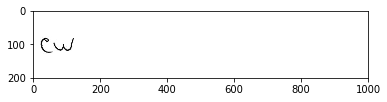

  'cw' -> 'mi<STOP>'


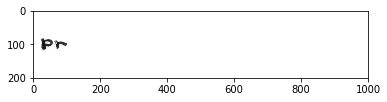

  'pr' -> 'ri<STOP>'


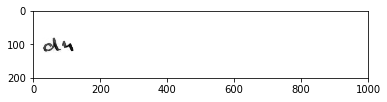

  'dn' -> 'rr<STOP>'
  Batch: 20 Loss: 2.43922199010849
100


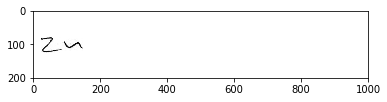

  'zn' -> 'mi<STOP>'


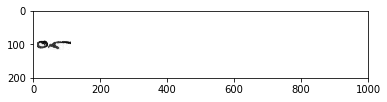

  'or' -> 'm<STOP><STOP>'


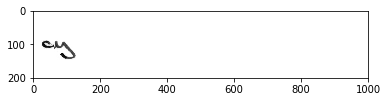

  'oy' -> 'wi<STOP>'
  Batch: 40 Loss: 2.3112959603468575
100


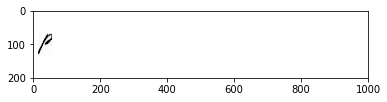

  'p' -> 'l<STOP>'


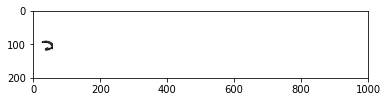

  's' -> 'b<STOP>'


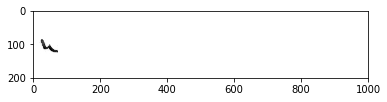

  'h' -> 'v<STOP>'
  Batch: 60 Loss: 2.182381894191106
100


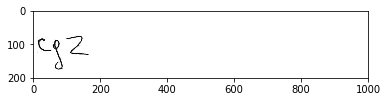

  'cgz' -> 'mw<STOP><STOP>'


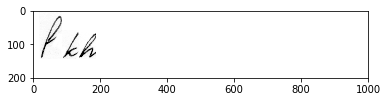

  'fkh' -> 'mzv<STOP>'


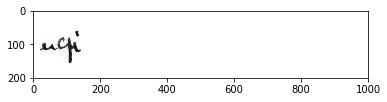

  'nqi' -> 'mx<STOP><STOP>'
  Batch: 80 Loss: 2.4461377064387
100


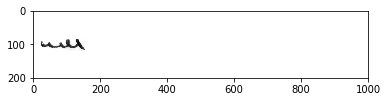

  'mu' -> 'mw<STOP>'


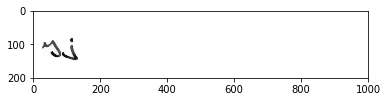

  'yj' -> 'ms<STOP>'


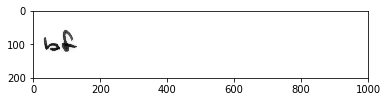

  'bf' -> 'ri<STOP>'
  Batch: 100 Loss: 2.1836954712867738
Test loss: 2.289650
Training epoch 5...
  Batch: 30 Loss: 2.160224583413866
  Batch: 60 Loss: 2.1703747550646466
  Batch: 90 Loss: 2.0642087592018976
  Batch: 120 Loss: 2.037231489022573
  Batch: 150 Loss: 2.035301423072815
  Batch: 180 Loss: 2.0615896781285605
  Batch: 210 Loss: 2.195227499802907
  Batch: 240 Loss: 2.1789952715237937
  Batch: 270 Loss: 2.1144249770376415
  Batch: 300 Loss: 2.104717400338915
  Batch: 330 Loss: 2.124755272600386
  Batch: 360 Loss: 2.083736417028639
  Batch: 390 Loss: 2.146572862731086
Train loss: 2.107086
Discr applied 0 times.
Testing...
100


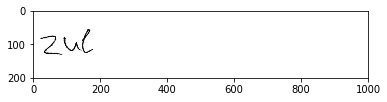

  'zul' -> 'mm<STOP><STOP>'


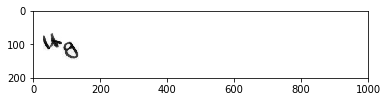

  'ltg' -> 'aq<STOP><STOP>'


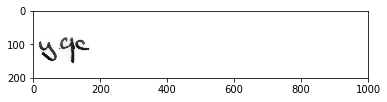

  'yqc' -> 'wv<STOP><STOP>'
  Batch: 20 Loss: 2.4240511794885
100


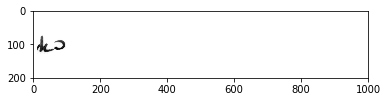

  'ks' -> 'al<STOP>'


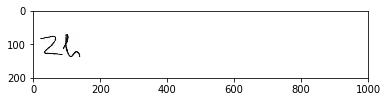

  'zh' -> 'ao<STOP>'


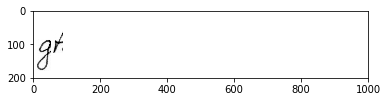

  'gt' -> 'li<STOP>'
  Batch: 40 Loss: 2.2572957177956896


In [0]:
for i in range(0, 100):
  max_size =3
  prob = 1
  randx = 20
  train(i, max_size, False, prob, randx, True)
  test(max_size, prob, randx)

In [0]:
save_net("/gdrive/My Drive/net3s.tar")

Network saved: /gdrive/My Drive/net3s.tar


Training epoch 0...
Discr loss: 1.352702
  Batch: 30 Loss: 1.4043908152315352
Discr loss: 1.219342
  Batch: 60 Loss: 1.407688020997577
Discr loss: 1.230822
  Batch: 90 Loss: 1.4844650308291116
Discr loss: 0.970205
  Batch: 120 Loss: 1.1957158598634932
Discr loss: 1.385803
  Batch: 150 Loss: 1.3728935016526116
Discr loss: 1.196915
  Batch: 180 Loss: 1.2665766570303174
Discr loss: 1.319584
  Batch: 210 Loss: 1.1266320380899644
Discr loss: 0.702557
  Batch: 240 Loss: 1.3391033596462671
Discr loss: 1.212175
  Batch: 270 Loss: 1.2839835584163664
Discr loss: 0.688609
  Batch: 300 Loss: 1.4631623605887092
Discr loss: 0.734977
  Batch: 330 Loss: 1.2397785961627963
Discr loss: 1.080423
  Batch: 360 Loss: 1.3477322075102065
Discr loss: 0.374291
  Batch: 390 Loss: 1.3026506364345551
Train loss: 1.319322
Discr applied 0 times.
Testing...
100


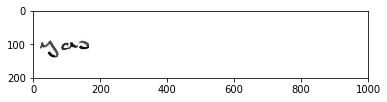

  'yas' -> 'yia<STOP>'


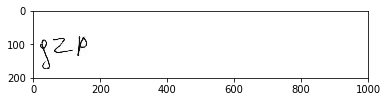

  'gzp' -> 'fz<STOP><STOP>'


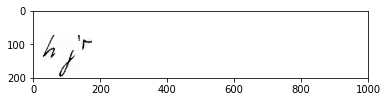

  'hjr' -> 'kjj<STOP>'
  Batch: 20 Loss: 1.627669733762741
100


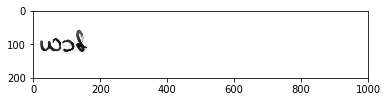

  'wsf' -> 'wct<STOP>'


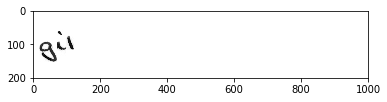

  'gil' -> 'jll<STOP>'


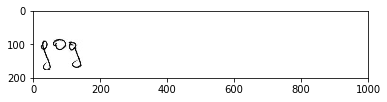

  'gog' -> 'gzb<STOP>'
  Batch: 40 Loss: 1.4404847651720047
100


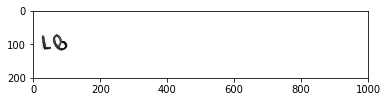

  'lb' -> 'if<STOP>'


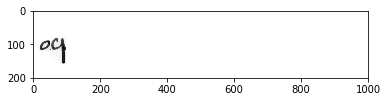

  'oq' -> 'rn<STOP>'


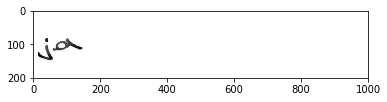

  'jd' -> 'jm<STOP>'
  Batch: 60 Loss: 1.4471693158149717
100


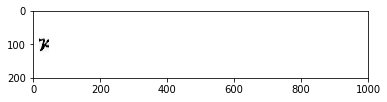

  'v' -> 'x<STOP>'


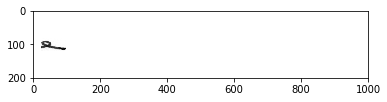

  'e' -> 'a<STOP>'


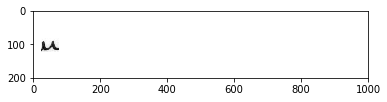

  'u' -> 'u<STOP>'
  Batch: 80 Loss: 1.2280753980080286
100


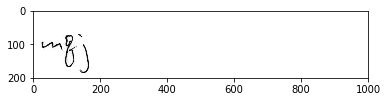

  'mqj' -> 'nyb<STOP>'


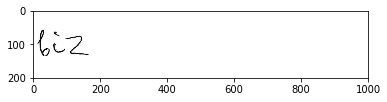

  'biz' -> 'hzj<STOP>'


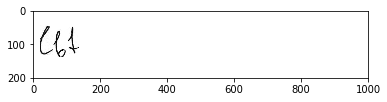

  'lbf' -> 'lgp<STOP>'
  Batch: 100 Loss: 1.1639719535907112
Test loss: 1.367796
Training epoch 1...
Discr loss: 0.240985
  Batch: 30 Loss: 1.2805641459094155
Discr loss: 0.406690
  Batch: 60 Loss: 1.4319894850254058
Discr loss: 0.555277
  Batch: 90 Loss: 1.2812709530194601
Discr loss: 0.343949
  Batch: 120 Loss: 1.3836281696955366
Discr loss: 0.243535
  Batch: 150 Loss: 1.3940389335155488
Discr loss: 0.921318
  Batch: 180 Loss: 1.347736757993698
Discr loss: 0.152349
  Batch: 210 Loss: 1.629089297188653
Discr loss: 0.043259
  Batch: 240 Loss: 1.5822146071328056
Discr loss: 0.987074
  Batch: 270 Loss: 1.604516104857127
Discr loss: 0.168851
  Batch: 300 Loss: 1.5431483083301119
Discr loss: 0.927983
  Batch: 330 Loss: 1.4746586104234056
Discr loss: 0.035078
  Batch: 360 Loss: 1.6302514725261266
Discr loss: 0.966911
  Batch: 390 Loss: 1.7423408733473884
Train loss: 1.486723
Discr applied 115 times.
Testing...
100


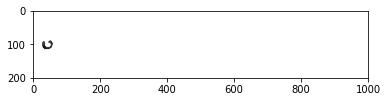

  'v' -> 'n<STOP>'


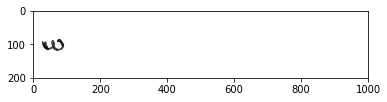

  'w' -> 'w<STOP>'


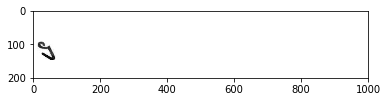

  'g' -> 'g<STOP>'
  Batch: 20 Loss: 1.89661382039388
100


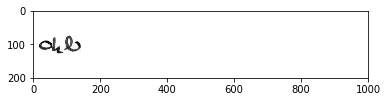

  'okb' -> 'up<STOP><STOP>'


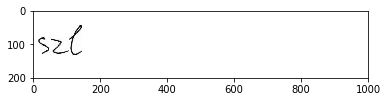

  'szl' -> 'zrs<STOP>'


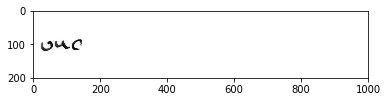

  'vuc' -> 'nvs<STOP>'
  Batch: 40 Loss: 1.7713143616914748
100


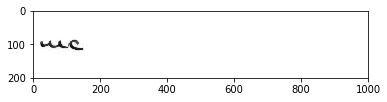

  'mc' -> 'me<STOP>'


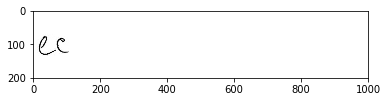

  'ec' -> 'ez<STOP>'


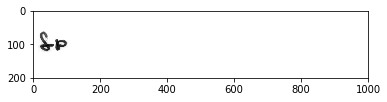

  'fp' -> 'wi<STOP>'
  Batch: 60 Loss: 1.6591956148544948
100


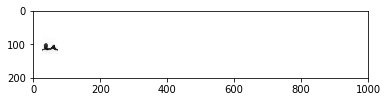

  'n' -> 'u<STOP>'


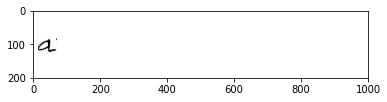

  'a' -> 'z<STOP>'


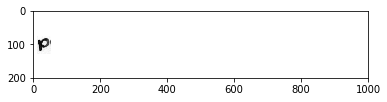

  'p' -> 'o<STOP>'
  Batch: 80 Loss: 1.5525179227193198
100


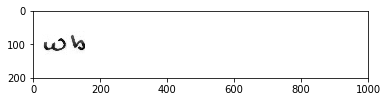

  'wb' -> 'kw<STOP>'


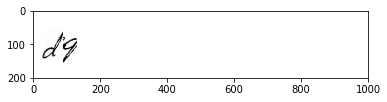

  'dq' -> 'df<STOP>'


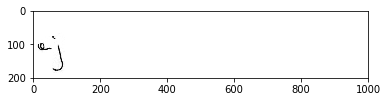

  'aj' -> 'cj<STOP>'
  Batch: 100 Loss: 1.711618121465047
Test loss: 1.701240
Training epoch 2...
Discr loss: 0.063728
  Batch: 30 Loss: 1.7653177804417082
Discr loss: 0.888595
  Batch: 60 Loss: 1.5726295775837367
Discr loss: 0.305858
  Batch: 90 Loss: 1.7931344476011064
Discr loss: 0.803454
  Batch: 120 Loss: 1.6951457328266566
Discr loss: 0.223002
  Batch: 150 Loss: 1.691513466172748
Discr loss: 0.002769
  Batch: 180 Loss: 1.74656655854649
Discr loss: 0.011754
  Batch: 210 Loss: 1.7546449575159286
Discr loss: 0.855181
  Batch: 240 Loss: 1.766443916161855
Discr loss: 0.046224
  Batch: 270 Loss: 1.989075556066301
Discr loss: 0.056703
  Batch: 300 Loss: 2.0141568554772276
Discr loss: 0.098679
  Batch: 330 Loss: 2.0374354322751365
Discr loss: 1.729558
  Batch: 360 Loss: 1.7680630975299407
Discr loss: 0.892032
  Batch: 390 Loss: 1.8880889932314553
Train loss: 1.804055
Discr applied 202 times.
Testing...
100


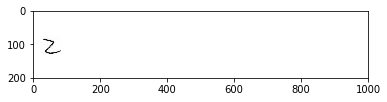

  'z' -> 'z<STOP>'


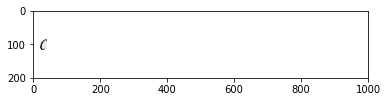

  'c' -> 'r<STOP>'


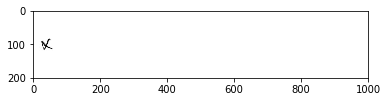

  'x' -> 'p<STOP>'
  Batch: 20 Loss: 1.8513367414474486
100


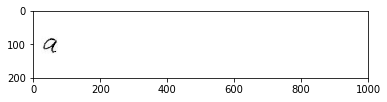

  'a' -> 'i<STOP>'


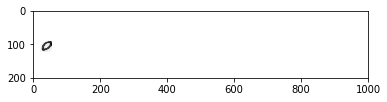

  'o' -> 'k<STOP>'


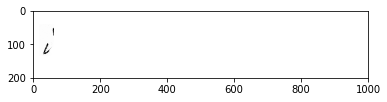

  'i' -> 'c<STOP>'
  Batch: 40 Loss: 1.637546386321386
100


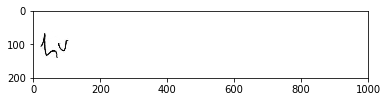

  'hv' -> 'bs<STOP>'


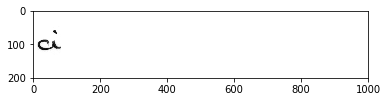

  'ci' -> 'ai<STOP>'


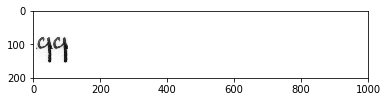

  'qq' -> 'yq<STOP>'
  Batch: 60 Loss: 2.0134644707043963
100


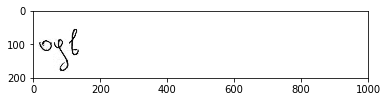

  'ogb' -> 'cw<STOP><STOP>'


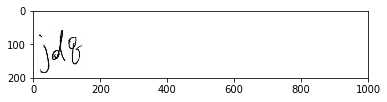

  'jdq' -> 'dh<STOP><STOP>'


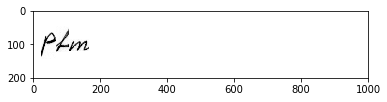

  'ptm' -> 'pqx<STOP>'
  Batch: 80 Loss: 1.83110994497935
100


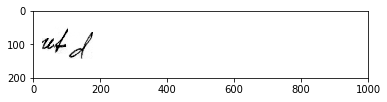

  'utd' -> 'md<STOP><STOP>'


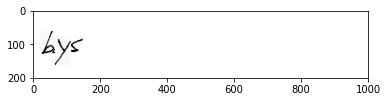

  'bys' -> 'kj<STOP><STOP>'


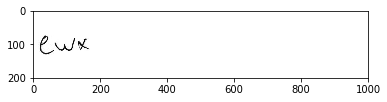

  'ewx' -> 'pmj<STOP>'
  Batch: 100 Loss: 1.7689497768878937
Test loss: 1.802457
Training epoch 3...
Discr loss: 0.752897
  Batch: 30 Loss: 1.8517467472288345
Discr loss: 0.123754
  Batch: 60 Loss: 1.787934985425737
Discr loss: 0.037551
  Batch: 90 Loss: 1.902645664744907
Discr loss: 0.126087
  Batch: 120 Loss: 2.0808408035172357
Discr loss: 0.035269
  Batch: 150 Loss: 1.944462752342224
Discr loss: 0.688243
  Batch: 180 Loss: 2.003185673554739
Discr loss: 0.057615
  Batch: 210 Loss: 2.0728290226724417
Discr loss: 0.006437
  Batch: 240 Loss: 2.0748953792783946
Discr loss: 0.057854
  Batch: 270 Loss: 2.189952886104584
Discr loss: 0.550093
  Batch: 300 Loss: 2.0749751965204877
Discr loss: 0.038817
  Batch: 330 Loss: 2.1555379046334155
Discr loss: 0.000915
  Batch: 360 Loss: 2.0953726132710777
Discr loss: 0.003184
  Batch: 390 Loss: 2.042153990268707
Train loss: 2.010675
Discr applied 213 times.
Testing...
100


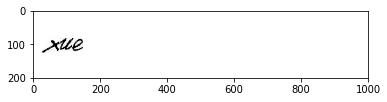

  'xue' -> 'xaa<STOP>'


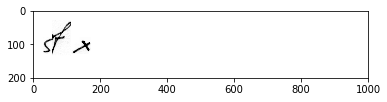

  'sfx' -> 'wm<STOP><STOP>'


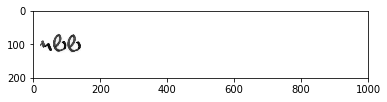

  'nbb' -> 'qll<STOP>'
  Batch: 20 Loss: 2.2088102201620736
100


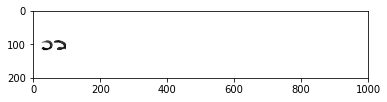

  'ss' -> 'u<STOP><STOP>'


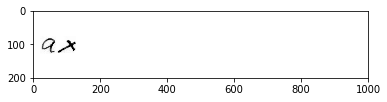

  'ax' -> 'xq<STOP>'


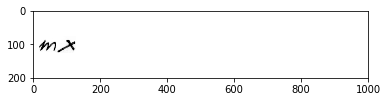

  'mx' -> 'mx<STOP>'
  Batch: 40 Loss: 2.1150381882985436
100


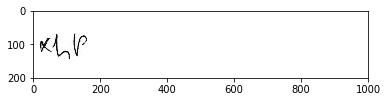

  'xhp' -> 'qqb<STOP>'


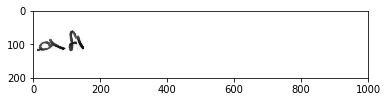

  'dfl' -> 'axt<STOP>'


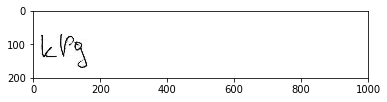

  'kpg' -> 'jxz<STOP>'
  Batch: 60 Loss: 2.1621636748313904
100


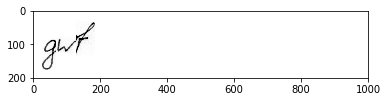

  'gwf' -> 'zxm<STOP>'


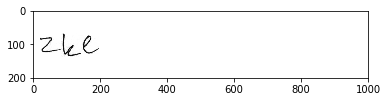

  'zke' -> 'mz<STOP><STOP>'


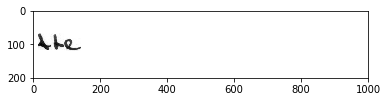

  'tte' -> 'tcp<STOP>'
  Batch: 80 Loss: 1.9849307219187415
100


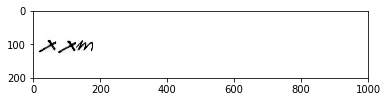

  'xxm' -> 'dmd<STOP>'


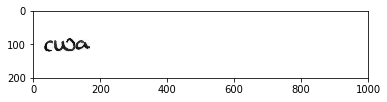

  'cwa' -> 'hm<STOP><STOP>'


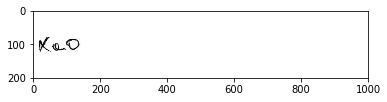

  'xao' -> 'wl<STOP><STOP>'
  Batch: 100 Loss: 2.2868691583474474
Test loss: 2.130260
Training epoch 4...
Discr loss: 0.439012
  Batch: 30 Loss: 2.127141061094072
Discr loss: 0.282510
  Batch: 60 Loss: 2.0504916270573936
Discr loss: 0.053920
  Batch: 90 Loss: 1.9674048595958284
Discr loss: 0.065390
  Batch: 120 Loss: 2.0557540721363496
Discr loss: 0.531551
  Batch: 150 Loss: 2.0791328814294605
Discr loss: 0.533498
  Batch: 180 Loss: 2.1084057145648534
Discr loss: 0.007969
  Batch: 210 Loss: 2.0187309000227187
Discr loss: 0.031591
  Batch: 240 Loss: 2.1168210175302296
Discr loss: 0.091201
  Batch: 270 Loss: 2.0316400276290048
Discr loss: 0.086201
  Batch: 300 Loss: 2.0722583532333374
Discr loss: 0.036842
  Batch: 330 Loss: 2.0782805548773875
Discr loss: 0.011151
  Batch: 360 Loss: 2.15817092789544
Discr loss: 0.009159
  Batch: 390 Loss: 2.056869477695889
Train loss: 2.061918
Discr applied 175 times.
Testing...
100


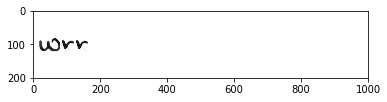

  'wrr' -> 'ox<STOP><STOP>'


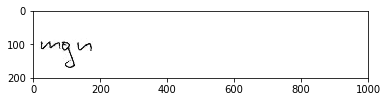

  'mgn' -> 'wd<STOP><STOP>'


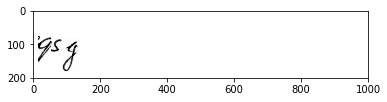

  'qsg' -> 'xf<STOP><STOP>'
  Batch: 20 Loss: 2.125363616148631
100


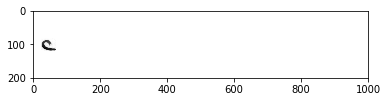

  'c' -> 'o<STOP>'


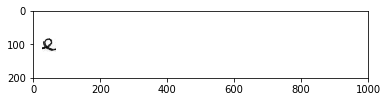

  'e' -> 'l<STOP>'


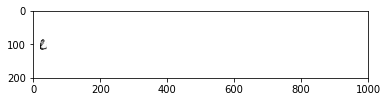

  'e' -> 'i<STOP>'
  Batch: 40 Loss: 2.276976410547892
100


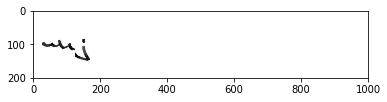

  'nhj' -> 'ied<STOP>'


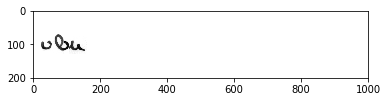

  'vbk' -> 'zp<STOP><STOP>'


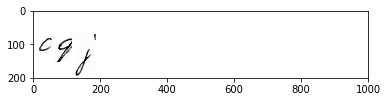

  'cqj' -> 'zdt<STOP>'
  Batch: 60 Loss: 2.166159119208654
100


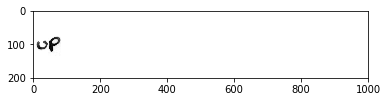

  'vp' -> 'g<STOP><STOP>'


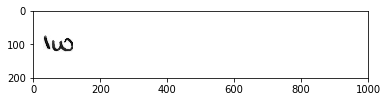

  'lw' -> 'yq<STOP>'


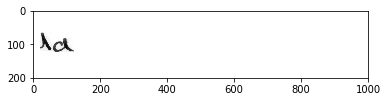

  'ld' -> 'bk<STOP>'
  Batch: 80 Loss: 2.2680133958657582
100


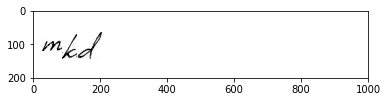

  'mkd' -> 'wmg<STOP>'


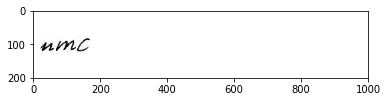

  'nmc' -> 'mj<STOP><STOP>'


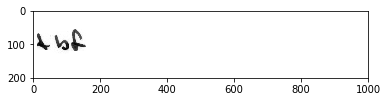

  'tbf' -> 'njp<STOP>'
  Batch: 100 Loss: 2.217663689454396
Test loss: 2.188946
Training epoch 5...
Discr loss: 0.006207
  Batch: 30 Loss: 2.232481178972456
Discr loss: 0.082206
  Batch: 60 Loss: 2.049935715728336
Discr loss: 0.004896
  Batch: 90 Loss: 2.177175533771515
Discr loss: 0.468359
  Batch: 120 Loss: 1.9622813913557267
Discr loss: 0.007500
  Batch: 150 Loss: 2.1384127775828046
Discr loss: 0.013871
  Batch: 180 Loss: 2.1213471902741325
Discr loss: 0.011923
  Batch: 210 Loss: 2.132029139995575
Discr loss: 0.010523
  Batch: 240 Loss: 2.179965915944841
Discr loss: 0.000843
  Batch: 270 Loss: 2.0841711613867018
Discr loss: 0.364559
  Batch: 300 Loss: 2.148427398999532
Discr loss: 0.000883
  Batch: 330 Loss: 1.9983340660730997
Discr loss: 0.002487
  Batch: 360 Loss: 2.114669386545817
Discr loss: 0.061267
  Batch: 390 Loss: 2.1126660201284624
Train loss: 2.105186
Discr applied 127 times.
Testing...
100


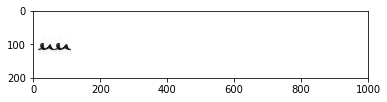

  'nn' -> 'nn<STOP>'


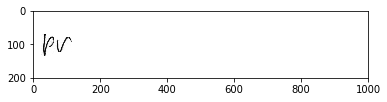

  'pr' -> 'fk<STOP>'


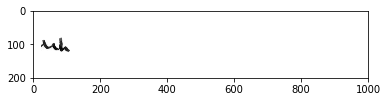

  'hh' -> 'rr<STOP>'
  Batch: 20 Loss: 2.2588455279668174
100


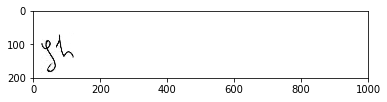

  'gh' -> 'dg<STOP>'


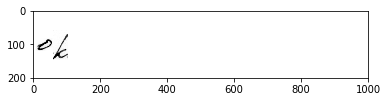

  'ok' -> 'qo<STOP>'


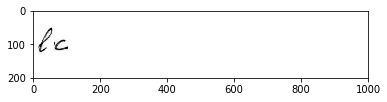

  'lc' -> 'r<STOP><STOP>'
  Batch: 40 Loss: 2.052079782883326
100


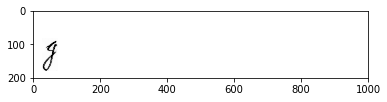

  'g' -> 'o<STOP>'


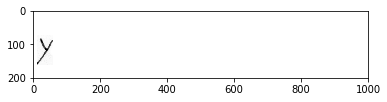

  'y' -> 'x<STOP>'


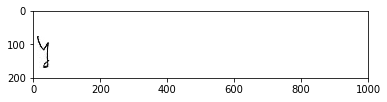

  'y' -> 'g<STOP>'
  Batch: 60 Loss: 2.128827166557312
100


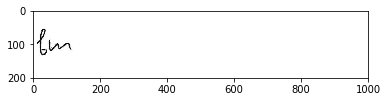

  'bm' -> 'ph<STOP>'


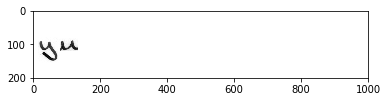

  'yu' -> 'qn<STOP>'


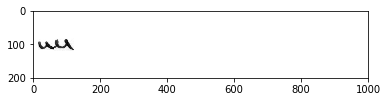

  'uu' -> 'zn<STOP>'
  Batch: 80 Loss: 2.044206174214681
100


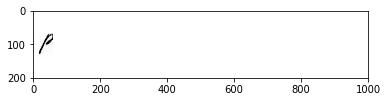

  'p' -> 'g<STOP>'


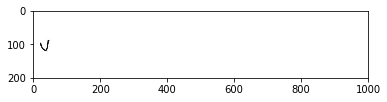

  'v' -> 'x<STOP>'


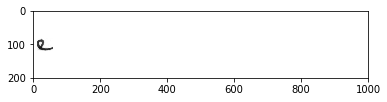

  'e' -> 'v<STOP>'
  Batch: 100 Loss: 1.9751542607943215
Test loss: 2.071111
Training epoch 6...
Discr loss: 0.110288
  Batch: 30 Loss: 2.1582918869124517
Discr loss: 0.001957
  Batch: 60 Loss: 2.126013967725966
Discr loss: 0.180997
  Batch: 90 Loss: 2.0213705725140043
Discr loss: 0.388942
  Batch: 120 Loss: 2.154533892207675
Discr loss: 0.450710
  Batch: 150 Loss: 2.125485212273068
Discr loss: 0.001304
  Batch: 180 Loss: 2.1160282664828833
Discr loss: 0.046548
  Batch: 210 Loss: 2.0957105265723333
Discr loss: 0.000913
  Batch: 240 Loss: 2.007522271739112
Discr loss: 0.381717
  Batch: 270 Loss: 2.086917225519816
Discr loss: 0.008585
  Batch: 300 Loss: 2.157132373915778
Discr loss: 0.377646
  Batch: 330 Loss: 1.9169874615139433
Discr loss: 0.012591
  Batch: 360 Loss: 2.17869827747345
Discr loss: 0.459020
  Batch: 390 Loss: 2.0290122191111246
Train loss: 2.084206
Discr applied 141 times.
Testing...
100


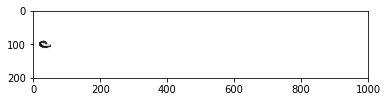

  'o' -> 'c<STOP>'


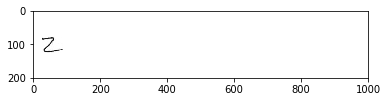

  'z' -> 'j<STOP>'


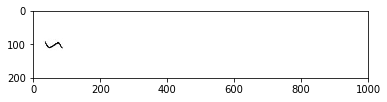

  'n' -> 'z<STOP>'
  Batch: 20 Loss: 2.1420772353808086
100


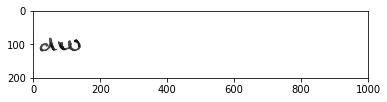

  'dw' -> 'sp<STOP>'


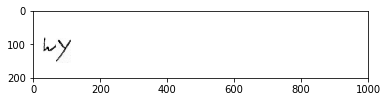

  'wy' -> 'rk<STOP>'


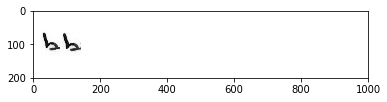

  'bb' -> 'm<STOP><STOP>'
  Batch: 40 Loss: 2.133656958738963
100


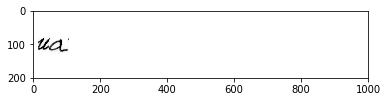

  'ua' -> 'j<STOP><STOP>'


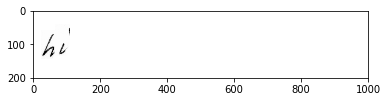

  'hi' -> 'lm<STOP>'


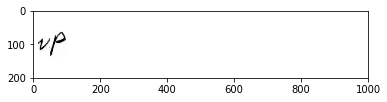

  'vp' -> 'xt<STOP>'
  Batch: 60 Loss: 1.9807814737161002
100


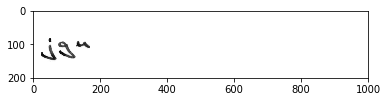

  'jgn' -> 'mj<STOP><STOP>'


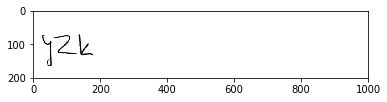

  'yzk' -> 'nw<STOP><STOP>'


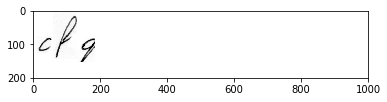

  'cfq' -> 'mbx<STOP>'
  Batch: 80 Loss: 2.303158356746038
100


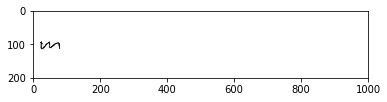

  'm' -> 'm<STOP>'


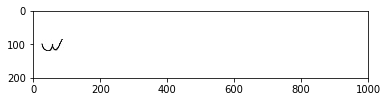

  'w' -> 'w<STOP>'


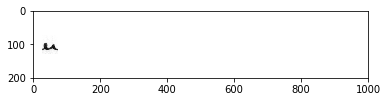

  'n' -> 'p<STOP>'
  Batch: 100 Loss: 1.9486352582772573
Test loss: 2.080853
Training epoch 7...
Discr loss: 0.006380
  Batch: 30 Loss: 2.23072712553872
Discr loss: 0.435902
  Batch: 60 Loss: 2.1377936667866178
Discr loss: 0.376126
  Batch: 90 Loss: 2.064752181371053
Discr loss: 0.580316
  Batch: 120 Loss: 1.8876295672522647
Discr loss: 0.002588
  Batch: 150 Loss: 2.008869394991133
Discr loss: 0.003829
  Batch: 180 Loss: 2.01644406053755
Discr loss: 0.423871
  Batch: 210 Loss: 1.965993148750729
Discr loss: 0.018126
  Batch: 240 Loss: 2.015901875495911
Discr loss: 0.057495
  Batch: 270 Loss: 2.1531546778149075
Discr loss: 0.000726
  Batch: 300 Loss: 2.0244482623206244
Discr loss: 0.000592
  Batch: 330 Loss: 2.061332212554084
Discr loss: 0.008943
  Batch: 360 Loss: 2.0106696459982127
Discr loss: 0.373982
  Batch: 390 Loss: 1.9591636406050792
Train loss: 2.033688
Discr applied 102 times.
Testing...
100


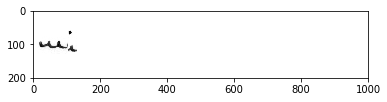

  'mi' -> 'hm<STOP>'


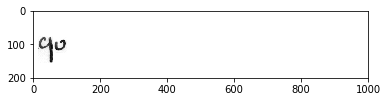

  'qv' -> 'ni<STOP>'


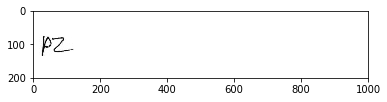

  'pz' -> 'w<STOP><STOP>'
  Batch: 20 Loss: 2.1123656392097474
100


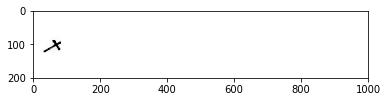

  'x' -> 'm<STOP>'


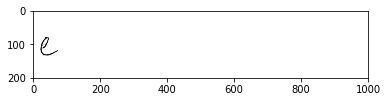

  'e' -> 'j<STOP>'


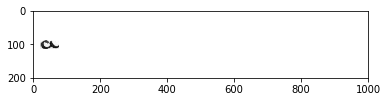

  'a' -> 'n<STOP>'
  Batch: 40 Loss: 2.157716526587804
100


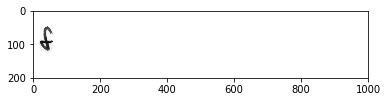

  'f' -> 'v<STOP>'


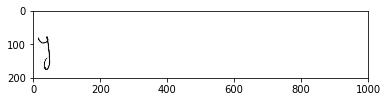

  'y' -> 'q<STOP>'


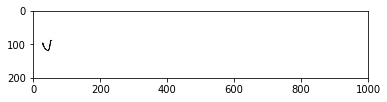

  'v' -> 'x<STOP>'
  Batch: 60 Loss: 2.143558621406555
100


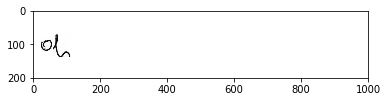

  'oh' -> 'ab<STOP>'


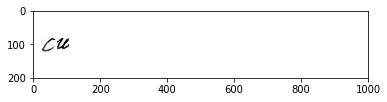

  'cu' -> 'ci<STOP>'


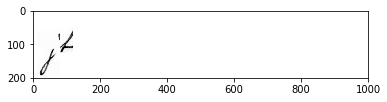

  'jt' -> 'mi<STOP>'
  Batch: 80 Loss: 2.32340583006541
100


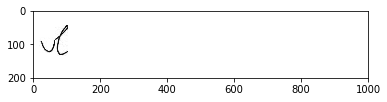

  'vl' -> 'wl<STOP>'


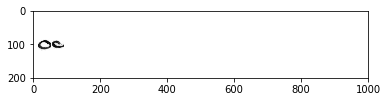

  'oo' -> 'si<STOP>'


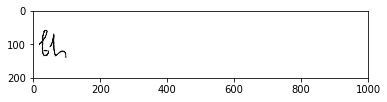

  'bh' -> 'bx<STOP>'
  Batch: 100 Loss: 2.092171394824982
Test loss: 2.144400
Training epoch 8...
Discr loss: 0.417901
  Batch: 30 Loss: 2.0978567361831666
Discr loss: 0.497692
  Batch: 60 Loss: 1.9177165455288356
Discr loss: 0.083681
  Batch: 90 Loss: 1.88378189139896
Discr loss: 0.014827
  Batch: 120 Loss: 2.03383551703559
Discr loss: 0.429421
  Batch: 150 Loss: 2.0906463013754952
Discr loss: 0.005058
  Batch: 180 Loss: 1.9596927483876547
Discr loss: 0.453944
  Batch: 210 Loss: 2.1197563343577914
Discr loss: 0.005300
  Batch: 240 Loss: 1.9780113021532695
Discr loss: 0.064249
  Batch: 270 Loss: 1.8664406405554876
Discr loss: 0.388512
  Batch: 300 Loss: 1.9699260248078239
Discr loss: 0.009457
  Batch: 330 Loss: 1.9843634406725563
Discr loss: 0.006757
  Batch: 360 Loss: 2.01091396941079
Discr loss: 0.532560
  Batch: 390 Loss: 1.8270626955562166
Train loss: 1.979597
Discr applied 122 times.
Testing...
100


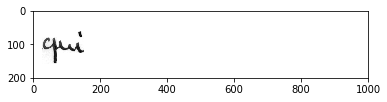

  'qhi' -> 'kb<STOP><STOP>'


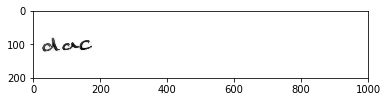

  'dac' -> 'jm<STOP><STOP>'


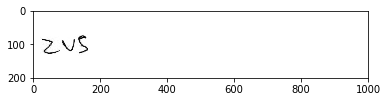

  'zvs' -> 'ajg<STOP>'
  Batch: 20 Loss: 2.3006057063738505
100


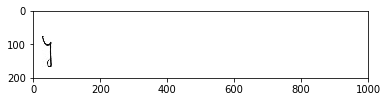

  'y' -> 'z<STOP>'


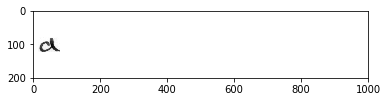

  'd' -> 'u<STOP>'


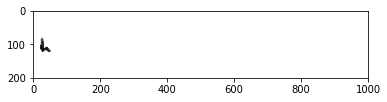

  'h' -> 'p<STOP>'
  Batch: 40 Loss: 1.8479861319065094
100


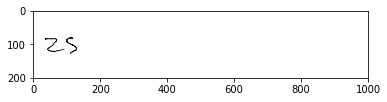

  'zs' -> 'az<STOP>'


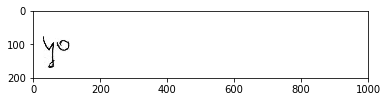

  'yo' -> 'sq<STOP>'


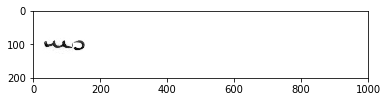

  'ms' -> 'ml<STOP>'
  Batch: 60 Loss: 1.956644707918167
100


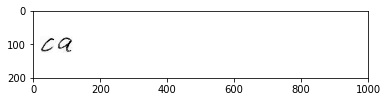

  'ca' -> 'mx<STOP>'


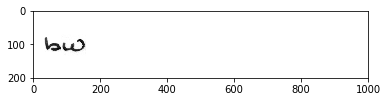

  'bw' -> 'mm<STOP>'


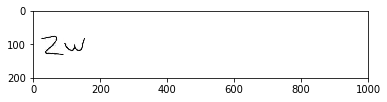

  'zw' -> 'zg<STOP>'
  Batch: 80 Loss: 2.051265879472097
100


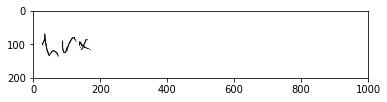

  'hrx' -> 'zx<STOP><STOP>'


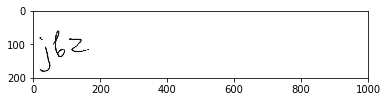

  'jbz' -> 'gqw<STOP>'


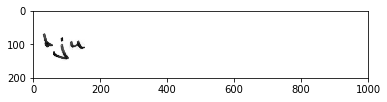

  'tju' -> 'oai<STOP>'
  Batch: 100 Loss: 1.95962553024292
Test loss: 2.003194
Training epoch 9...
Discr loss: 0.458335
  Batch: 30 Loss: 2.0302274611261155
Discr loss: 0.403311
  Batch: 60 Loss: 1.9221069124009873
Discr loss: 0.121560
  Batch: 90 Loss: 1.9953499767515397
Discr loss: 0.014567
  Batch: 120 Loss: 2.0002090281910365
Discr loss: 0.426971
  Batch: 150 Loss: 2.1305200762218903
Discr loss: 0.002581
  Batch: 180 Loss: 2.0008106695281134
Discr loss: 0.003350
  Batch: 210 Loss: 2.0227257569630943
Discr loss: 0.650271
  Batch: 240 Loss: 2.142859207259284
Discr loss: 0.000428
  Batch: 270 Loss: 1.8921323418617246
Discr loss: 0.011706
  Batch: 300 Loss: 2.0464666737450496
Discr loss: 0.473922
  Batch: 330 Loss: 1.98499899175432
Discr loss: 0.011983
  Batch: 360 Loss: 2.081171165572272
Discr loss: 0.130742
  Batch: 390 Loss: 1.9777211096551681
Train loss: 2.012351
Discr applied 149 times.
Testing...
100


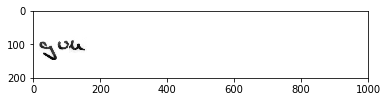

  'gvk' -> 'zl<STOP><STOP>'


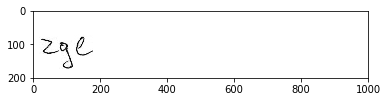

  'zge' -> 'ggg<STOP>'


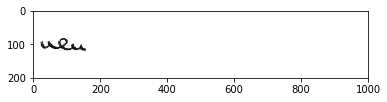

  'uen' -> 'ijh<STOP>'
  Batch: 20 Loss: 2.2352586905161536
100


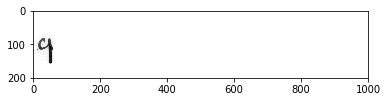

  'q' -> 'u<STOP>'


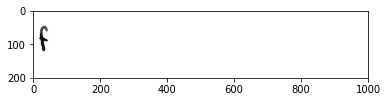

  'f' -> 'c<STOP>'


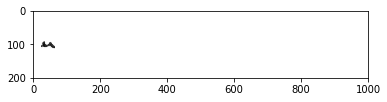

  'n' -> 'm<STOP>'
  Batch: 40 Loss: 2.3331315239270527
100


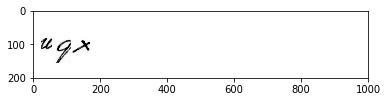

  'uqx' -> 'mu<STOP><STOP>'


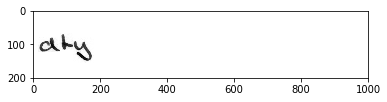

  'dty' -> 'mj<STOP><STOP>'


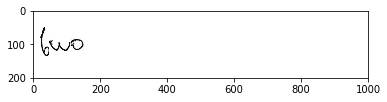

  'bwo' -> 'yg<STOP><STOP>'
  Batch: 60 Loss: 1.9792931238810219
100


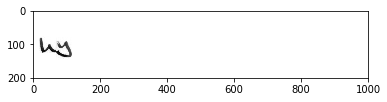

  'hy' -> 'yu<STOP>'


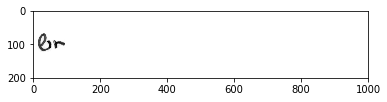

  'br' -> 'gl<STOP>'


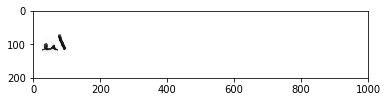

  'nl' -> 'uo<STOP>'
  Batch: 80 Loss: 2.1672196904818217
100


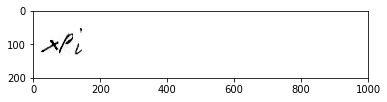

  'xpi' -> 'zel<STOP>'


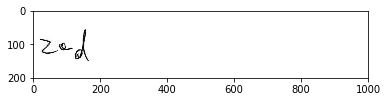

  'zad' -> 'imn<STOP>'


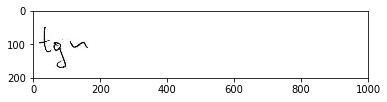

  'tgn' -> 'uuw<STOP>'
  Batch: 100 Loss: 2.0286074797312414
Test loss: 2.127428
Training epoch 10...
Discr loss: 0.004303
  Batch: 30 Loss: 1.987815279430813
Discr loss: 0.651070
  Batch: 60 Loss: 1.8559239069620768
Discr loss: 0.007406
  Batch: 90 Loss: 1.9203198181258303
Discr loss: 0.016724
  Batch: 120 Loss: 2.029410145017836
Discr loss: 0.030716
  Batch: 150 Loss: 1.9697243624263339
Discr loss: 0.001679
  Batch: 180 Loss: 2.0580486628744334
Discr loss: 0.105940
  Batch: 210 Loss: 1.8610908720228403
Discr loss: 0.029762
  Batch: 240 Loss: 1.9979118320677014
Discr loss: 0.003737
  Batch: 270 Loss: 1.9896536880069309
Discr loss: 0.083880
  Batch: 300 Loss: 1.9823310322231718
Discr loss: 0.003581
  Batch: 330 Loss: 1.8313656648000083
Discr loss: 0.112718
  Batch: 360 Loss: 1.8222762425740557
Discr loss: 0.130539
  Batch: 390 Loss: 1.838870096206665
Train loss: 1.931640
Discr applied 170 times.
Testing...
100


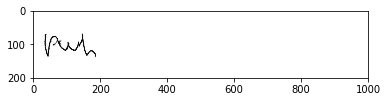

  'pwh' -> 'fmq<STOP>'


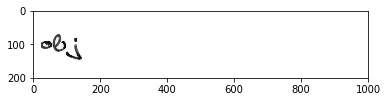

  'obj' -> 'xrm<STOP>'


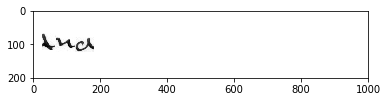

  'tud' -> 'kwo<STOP>'
  Batch: 20 Loss: 2.2429115692774455
100


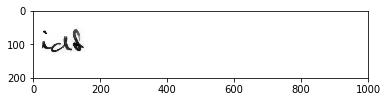

  'idf' -> 'tij<STOP>'


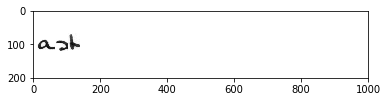

  'ast' -> 'feg<STOP>'


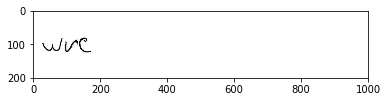

  'wrc' -> 'zeo<STOP>'
  Batch: 40 Loss: 2.1024025062719978
100


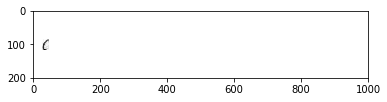

  'c' -> 'i<STOP>'


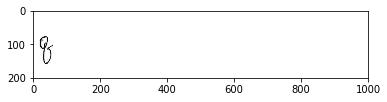

  'q' -> 'f<STOP>'


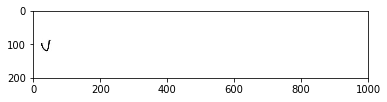

  'v' -> 'y<STOP>'
  Batch: 60 Loss: 2.072458791732788
100


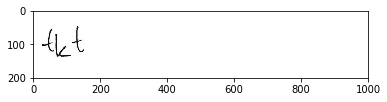

  'tkt' -> 'xft<STOP>'


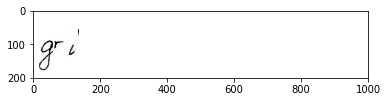

  'gri' -> 'jn<STOP><STOP>'


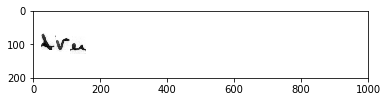

  'trn' -> 'ktc<STOP>'
  Batch: 80 Loss: 1.8214823464552559
100


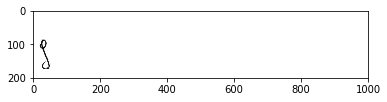

  'g' -> 'g<STOP>'


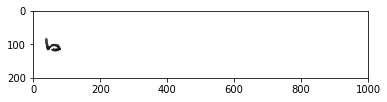

  'b' -> 'x<STOP>'


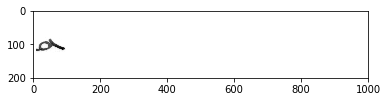

  'd' -> 'm<STOP>'
  Batch: 100 Loss: 1.992577731609345
Test loss: 2.026106
Training epoch 11...
Discr loss: 0.001639
  Batch: 30 Loss: 2.0098817110061646
Discr loss: 0.191872
  Batch: 60 Loss: 2.0714928030967714
Discr loss: 0.526746
  Batch: 90 Loss: 2.038270535733965
Discr loss: 0.008438
  Batch: 120 Loss: 1.8861515005429583
Discr loss: 0.022959
  Batch: 150 Loss: 1.9903527948591444
Discr loss: 0.578443
  Batch: 180 Loss: 1.9229065272543167
Discr loss: 0.000973
  Batch: 210 Loss: 2.041969622506036
Discr loss: 0.005067
  Batch: 240 Loss: 2.0405378884739345
Discr loss: 0.013522
  Batch: 270 Loss: 1.8886352088716296
Discr loss: 0.007825
  Batch: 300 Loss: 2.012482825915019
Discr loss: 0.006443
  Batch: 330 Loss: 1.9315402136908637
Discr loss: 0.041966
  Batch: 360 Loss: 1.8193465775913664
Discr loss: 0.004679
  Batch: 390 Loss: 1.9191267755296493
Train loss: 1.952853
Discr applied 159 times.
Testing...
100


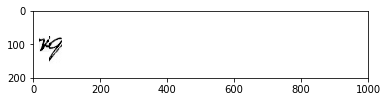

  'vq' -> 'y<STOP><STOP>'


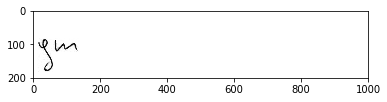

  'gm' -> 'xq<STOP>'


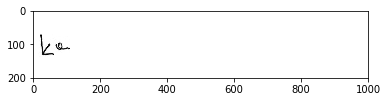

  'ka' -> 'lz<STOP>'
  Batch: 20 Loss: 2.157286270459493
100


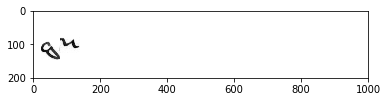

  'gu' -> 'xo<STOP>'


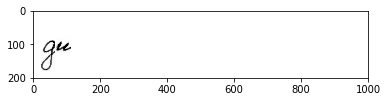

  'gu' -> 'm<STOP><STOP>'


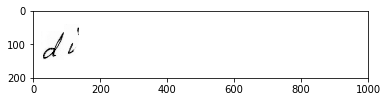

  'di' -> 'sbo'
  Batch: 40 Loss: 2.1069275240103407
100


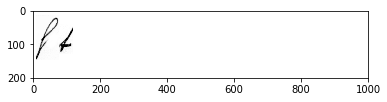

  'ft' -> 'dt<STOP>'


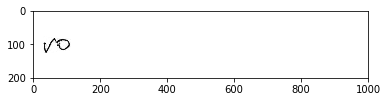

  'ro' -> 'dx<STOP>'


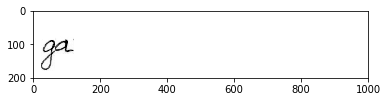

  'ga' -> 'gb<STOP>'
  Batch: 60 Loss: 1.9313394924004872
100


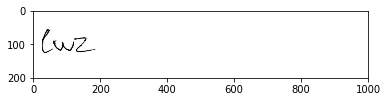

  'lwz' -> 'zxt<STOP>'


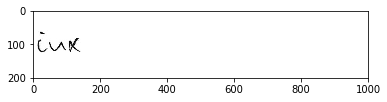

  'iux' -> 'jbv<STOP>'


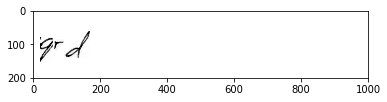

  'qrd' -> 'pfp<STOP>'
  Batch: 80 Loss: 2.055761229991913
100


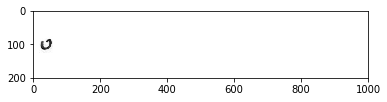

  'v' -> 'o<STOP>'


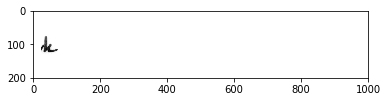

  'k' -> 'f<STOP>'


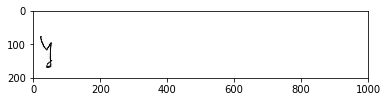

  'y' -> 'g<STOP>'
  Batch: 100 Loss: 1.8655435979366302
Test loss: 2.003338
Training epoch 12...
Discr loss: 0.665848
  Batch: 30 Loss: 1.7372181057929992
Discr loss: 0.060867
  Batch: 60 Loss: 1.9465618756082321
Discr loss: 0.024615
  Batch: 90 Loss: 1.9975990388128495
Discr loss: 0.527521
  Batch: 120 Loss: 1.9824021630816988
Discr loss: 0.517289
  Batch: 150 Loss: 1.8879697773191662
Discr loss: 0.014847
  Batch: 180 Loss: 1.801142503155602
Discr loss: 0.096482
  Batch: 210 Loss: 1.9853101650873817
Discr loss: 0.003810
  Batch: 240 Loss: 2.0663149396578473
Discr loss: 0.062581
  Batch: 270 Loss: 2.0224641150898406
Discr loss: 0.002874
  Batch: 300 Loss: 2.030612059434255
Discr loss: 0.007665
  Batch: 330 Loss: 1.8985695507791307
Discr loss: 0.013313
  Batch: 360 Loss: 2.0379552920659383
Discr loss: 0.122077
  Batch: 390 Loss: 1.9470568550957572
Train loss: 1.948027
Discr applied 186 times.
Testing...
100


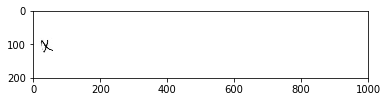

  'x' -> 'z<STOP>'


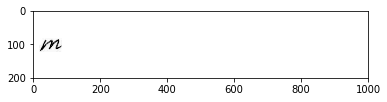

  'm' -> 'pm'


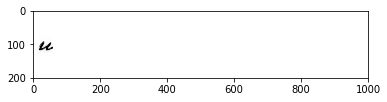

  'u' -> 'u<STOP>'
  Batch: 20 Loss: 1.9814843654632572
100


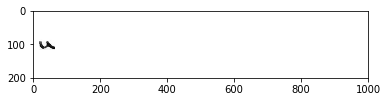

  'u' -> 'p<STOP>'


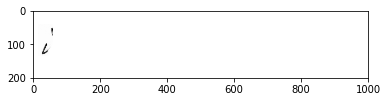

  'i' -> 'c<STOP>'


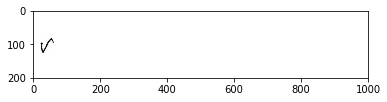

  'r' -> 'g<STOP>'
  Batch: 40 Loss: 2.166940325498581
100


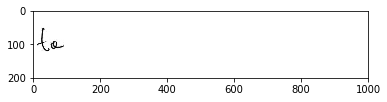

  'ta' -> 'lm<STOP>'


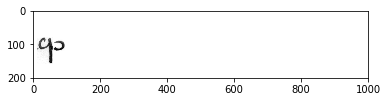

  'qs' -> 'vb<STOP>'


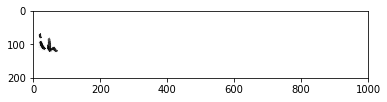

  'ih' -> 'kl<STOP>'
  Batch: 60 Loss: 2.013598455985387
100


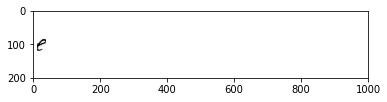

  'e' -> 'f<STOP>'


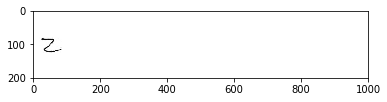

  'z' -> 'z<STOP>'


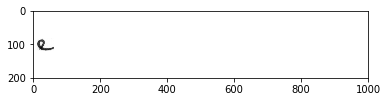

  'e' -> 'e<STOP>'
  Batch: 80 Loss: 1.9383405268192289
100


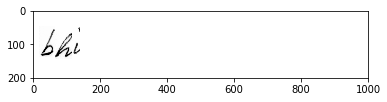

  'bhi' -> 'fbq<STOP>'


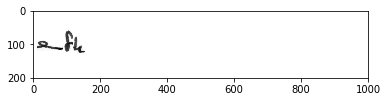

  'efk' -> 'fgg<STOP>'


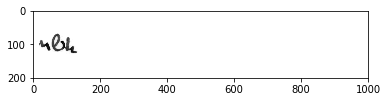

  'nbk' -> 'xk<STOP><STOP>'
  Batch: 100 Loss: 2.1218713144461314
Test loss: 2.024205
Training epoch 13...
Discr loss: 0.005264
  Batch: 30 Loss: 2.031087300512526
Discr loss: 0.189541
  Batch: 60 Loss: 1.8168768962224324
Discr loss: 0.126357
  Batch: 90 Loss: 1.985219959417979
Discr loss: 0.380462
  Batch: 120 Loss: 2.0290289402008055
Discr loss: 0.062164
  Batch: 150 Loss: 1.92800465159946
Discr loss: 0.012250
  Batch: 180 Loss: 1.9846741120020548
Discr loss: 0.001344
  Batch: 210 Loss: 2.0508741670184665
Discr loss: 0.530876
  Batch: 240 Loss: 1.841539435916477
Discr loss: 0.014198
  Batch: 270 Loss: 1.9228252715534635
Discr loss: 0.663345
  Batch: 300 Loss: 1.7767393297619292
Discr loss: 0.004811
  Batch: 330 Loss: 1.9652412639723886
Discr loss: 0.002642
  Batch: 360 Loss: 1.9290837672021655
Discr loss: 0.445190
  Batch: 390 Loss: 1.9333253529336716
Train loss: 1.933173
Discr applied 150 times.
Testing...
100


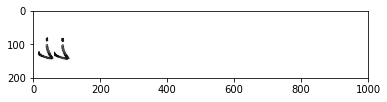

  'jj' -> 'zl<STOP>'


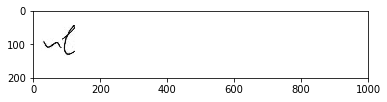

  'nl' -> 'mj<STOP>'


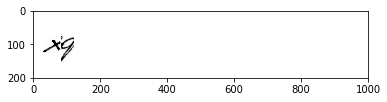

  'xq' -> 'di<STOP>'
  Batch: 20 Loss: 2.305518112579981
100


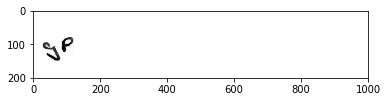

  'gp' -> 'yt<STOP>'


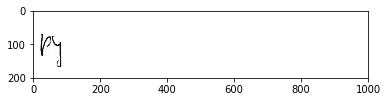

  'py' -> 'm<STOP><STOP>'


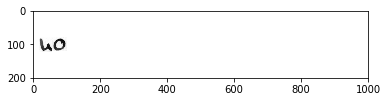

  'ho' -> 'm<STOP><STOP>'
  Batch: 40 Loss: 1.845222516854604
100


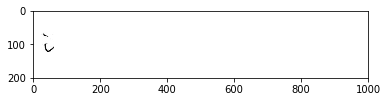

  'i' -> 'i<STOP>'


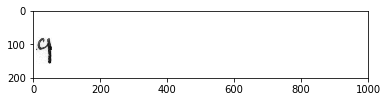

  'q' -> 'o<STOP>'


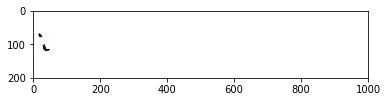

  'i' -> 'l<STOP>'
  Batch: 60 Loss: 1.874990024169286
100


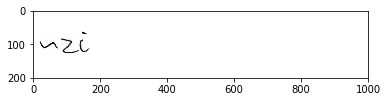

  'nzi' -> 'niy<STOP>'


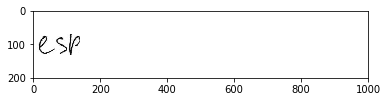

  'esp' -> 'zgs<STOP>'


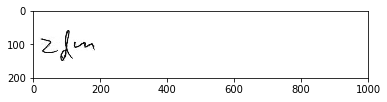

  'zdm' -> 'wxz<STOP>'
  Batch: 80 Loss: 1.9768814305464424
100


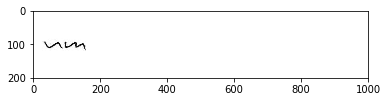

  'nm' -> 'mz<STOP>'


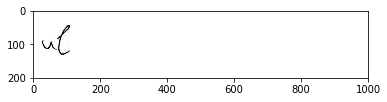

  'ul' -> 'wp<STOP>'


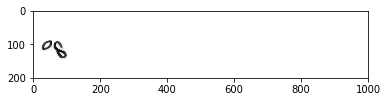

  'og' -> 'gv<STOP>'
  Batch: 100 Loss: 1.991242311398188
Test loss: 1.978981
Training epoch 14...
Discr loss: 0.002406
  Batch: 30 Loss: 1.9895256625281441
Discr loss: 0.552137
  Batch: 60 Loss: 2.033510348531935
Discr loss: 0.544464
  Batch: 90 Loss: 1.8645402828852338
Discr loss: 0.067730
  Batch: 120 Loss: 1.8023933105998573
Discr loss: 0.003478
  Batch: 150 Loss: 1.9229953779114615
Discr loss: 0.019190
  Batch: 180 Loss: 1.7345745907889472
Discr loss: 0.562165
  Batch: 210 Loss: 1.7774749795595803
Discr loss: 0.332907
  Batch: 240 Loss: 1.9063270688056944
Discr loss: 0.756507
  Batch: 270 Loss: 1.7620088060696917
Discr loss: 0.053291
  Batch: 300 Loss: 1.9719726098908317
Discr loss: 0.710230
  Batch: 330 Loss: 2.0568460702896116
Discr loss: 0.589689
  Batch: 360 Loss: 2.0071549918916487
Discr loss: 0.011878
  Batch: 390 Loss: 1.9184169027540419
Train loss: 1.902649
Discr applied 144 times.
Testing...
100


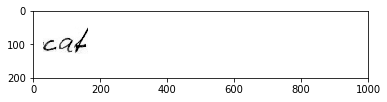

  'cat' -> 'mt<STOP><STOP>'


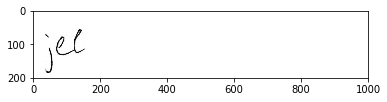

  'jel' -> 'xiv<STOP>'


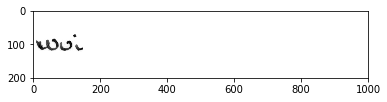

  'wvi' -> 'zlf<STOP>'
  Batch: 20 Loss: 2.1750717679659526
100


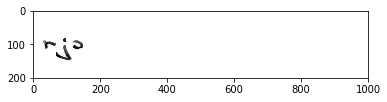

  'rjs' -> 'rin<STOP>'


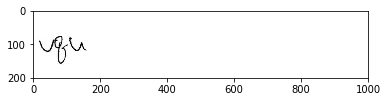

  'vqu' -> 'qgh<STOP>'


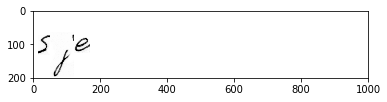

  'sje' -> 'fep<STOP>'
  Batch: 40 Loss: 2.1479996899763742
100


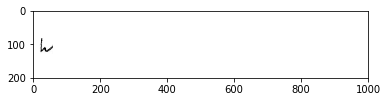

  'w' -> 'p<STOP>'


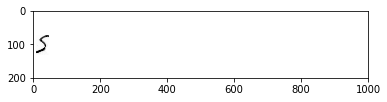

  's' -> 'c<STOP>'


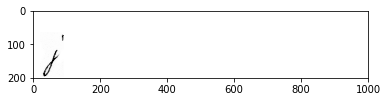

  'j' -> 'j<STOP>'
  Batch: 60 Loss: 2.0952010711034137
100


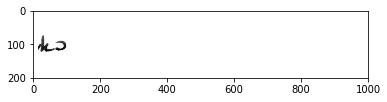

  'ks' -> 'ee<STOP>'


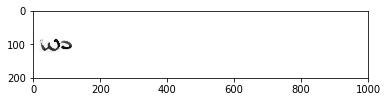

  'ws' -> 'ay<STOP>'


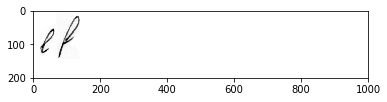

  'lf' -> 'wc<STOP>'
  Batch: 80 Loss: 2.1683708727359776
100


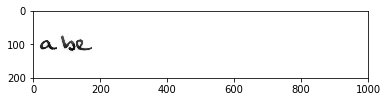

  'abe' -> 'vz<STOP><STOP>'


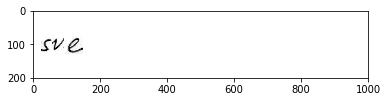

  'sve' -> 'cvq<STOP>'


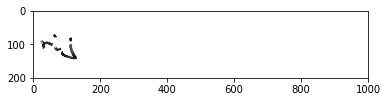

  'rij' -> 'zi<STOP><STOP>'
  Batch: 100 Loss: 2.043781159321467
Test loss: 2.105035


In [0]:
for i in range(0, 15):
  max_size = 3
  prob = 1
  randx=20
  train(i, max_size, True, prob, randx, True)
  test(max_size, prob, randx)


Training epoch 0...
  Batch: 30 Loss: 2.9274865683929
  Batch: 60 Loss: 2.7892873579484454
  Batch: 90 Loss: 2.679036889542978
  Batch: 120 Loss: 2.45217231864021
  Batch: 150 Loss: 2.560332666225534
  Batch: 180 Loss: 2.3891517999310974
  Batch: 210 Loss: 2.4510633401643664
  Batch: 240 Loss: 2.5067861718980096
  Batch: 270 Loss: 2.596450757866814
  Batch: 300 Loss: 2.4743534462792534
  Batch: 330 Loss: 2.425007303114291
  Batch: 360 Loss: 2.3900290614208846
  Batch: 390 Loss: 2.436963962562501
Train loss: 3.348032
Discr applied 0 times.
Testing...
100


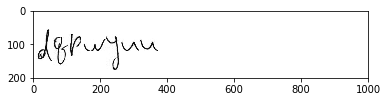

  'dqpwyuu' -> 'iepsehh<STOP>'


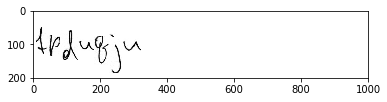

  'fpduqju' -> 'zxjbghr<STOP>'


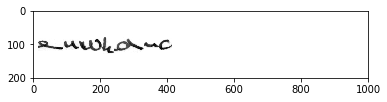

  'euwkdnc' -> 'iinpinm<STOP>'
  Batch: 20 Loss: 2.6336628426635076
100


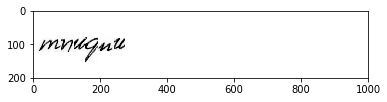

  'mnuqnu' -> 'xnsmas<STOP>'


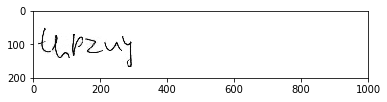

  'thpzuy' -> 'zovchi<STOP>'


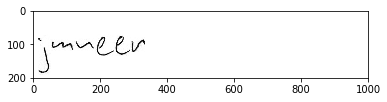

  'jmneer' -> 'znkccx<STOP>'
  Batch: 40 Loss: 2.4292376605291213
100


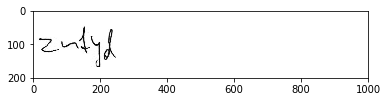

  'znfyd' -> 'wwhl<STOP><STOP>'


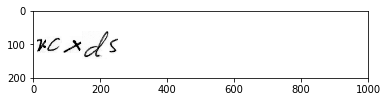

  'vcxds' -> 'ipylz<STOP>'


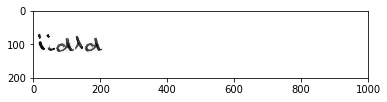

  'iidld' -> 'tpehi<STOP>'
  Batch: 60 Loss: 2.612173011832767
100


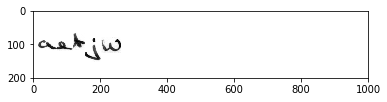

  'aetjw' -> 'tpnds<STOP>'


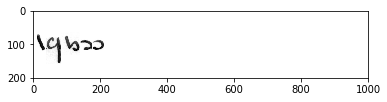

  'lqbss' -> 'ipknv<STOP>'


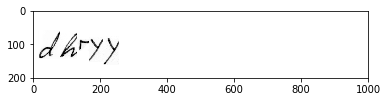

  'dhryy' -> 'dmgxs<STOP>'
  Batch: 80 Loss: 2.4250769560866887
100


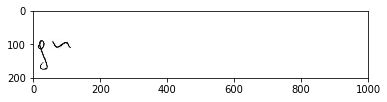

  'gn' -> 'kx<STOP>'


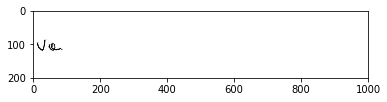

  'va' -> 'dc<STOP>'


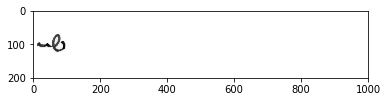

  'nb' -> 'kn<STOP>'
  Batch: 100 Loss: 2.4123281986562035
Test loss: 2.477719
Training epoch 1...
  Batch: 30 Loss: 2.5992490281882112
  Batch: 60 Loss: 2.5077985251012933
  Batch: 90 Loss: 2.5322379395444554
  Batch: 120 Loss: 2.519845098540896
  Batch: 150 Loss: 2.620305431254957
  Batch: 180 Loss: 2.679921514622118
  Batch: 210 Loss: 2.631431535930231
  Batch: 240 Loss: 2.6456504972775776
  Batch: 270 Loss: 2.6284258604175834
  Batch: 300 Loss: 2.561578160669437
  Batch: 330 Loss: 2.628474259351297
  Batch: 360 Loss: 2.6111953093639757
  Batch: 390 Loss: 2.5774528441353444
Train loss: 3.279396
Discr applied 0 times.
Testing...
100


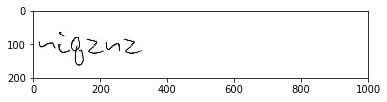

  'niqznz' -> 'mnyyz<STOP><STOP>'


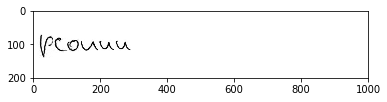

  'pcouuu' -> 'dhzyx<STOP><STOP>'


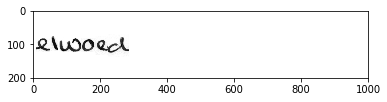

  'elwoed' -> 'tyoyd<STOP><STOP>'
  Batch: 20 Loss: 2.8575265890265262
100


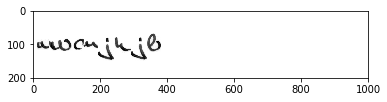

  'uwcnjkjb' -> 'myyyydx<STOP><STOP>'


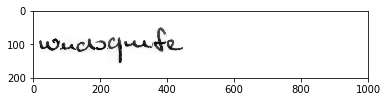

  'wndsqmfe' -> 'ozpbddyd<STOP>'


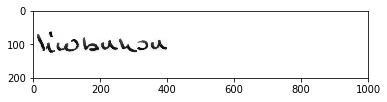

  'liwbuhsu' -> 'djyyyzx<STOP><STOP>'
  Batch: 40 Loss: 2.5851258698342336
100


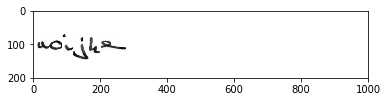

  'uoijke' -> 'ttbzv<STOP><STOP>'


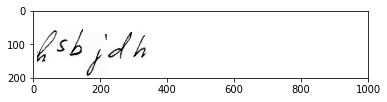

  'hsbjdh' -> 'mmyyd<STOP><STOP>'


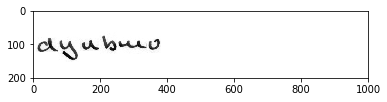

  'dyubmv' -> 'tyoydy<STOP>'
  Batch: 60 Loss: 2.6612453222464003
100


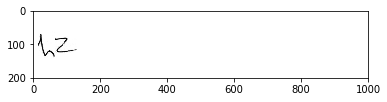

  'hz' -> 'yn<STOP>'


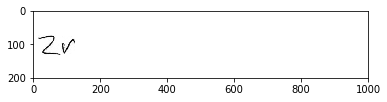

  'zr' -> 'yx<STOP>'


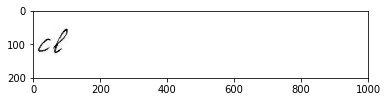

  'cl' -> 'xf<STOP>'
  Batch: 80 Loss: 2.353959496078037
100


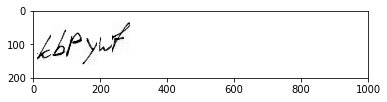

  'kbpywf' -> 'yxyxx<STOP><STOP>'


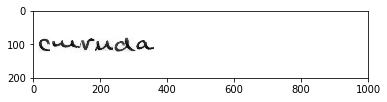

  'cmruda' -> 'tyyyxx<STOP>'


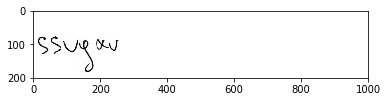

  'ssvgxv' -> 'tysyz<STOP><STOP>'
  Batch: 100 Loss: 2.7028197968384577
Test loss: 2.606075
Training epoch 2...
  Batch: 30 Loss: 2.7846175279440706
  Batch: 60 Loss: 2.5114419199802254
  Batch: 90 Loss: 2.5155061643968812
  Batch: 120 Loss: 2.741292897355619
  Batch: 150 Loss: 2.618642951256384
  Batch: 180 Loss: 2.4877790160280053
  Batch: 210 Loss: 2.7173953360855263
  Batch: 240 Loss: 2.6661045873985088
  Batch: 270 Loss: 2.5447533748515694
  Batch: 300 Loss: 2.5595684614383356
  Batch: 330 Loss: 2.4300678387520804
  Batch: 360 Loss: 2.5222628848641
  Batch: 390 Loss: 2.54552617488084
Train loss: 3.298974
Discr applied 0 times.
Testing...
100


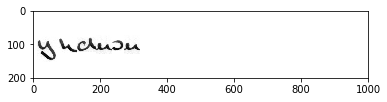

  'yhdnsn' -> 'axjjjt<STOP>'


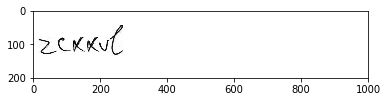

  'zcxxvl' -> 'hqzjjn<STOP>'


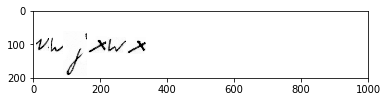

  'vwjxwx' -> 'vnjyzz<STOP>'
  Batch: 20 Loss: 2.5724498480463787
100


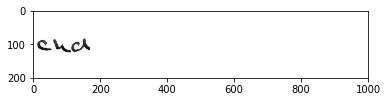

  'chd' -> 'wqf<STOP>'


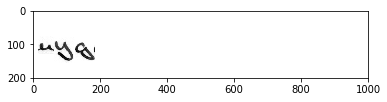

  'nyg' -> 'ajf<STOP>'


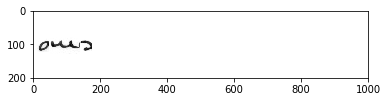

  'oms' -> 'zjj<STOP>'
  Batch: 40 Loss: 2.563383364298987
100


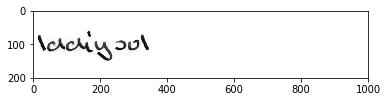

  'lddiysvl' -> 'wwzjzjs<STOP><STOP>'


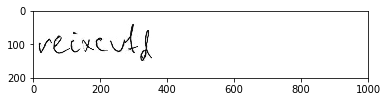

  'reixcvfd' -> 'zjzjjjz<STOP><STOP>'


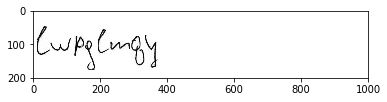

  'lwpglmqy' -> 'hzjjmzj<STOP><STOP>'
  Batch: 60 Loss: 2.620456651676269
100


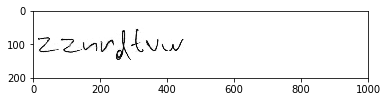

  'zznrdtvw' -> 'jzjzzznj<STOP>'


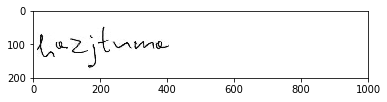

  'hazjtnma' -> 'wnjzzjl<STOP><STOP>'


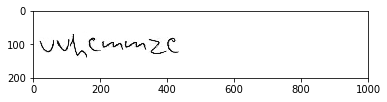

  'vvhcmmzc' -> 'azmjzzz<STOP><STOP>'
  Batch: 80 Loss: 2.5711508211446192
100


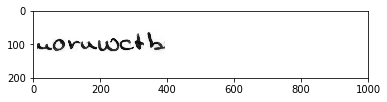

  'noruwctb' -> 'jjjjjjjm<STOP>'


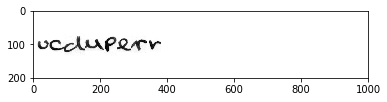

  'vcduperr' -> 'wzzjzmj<STOP><STOP>'


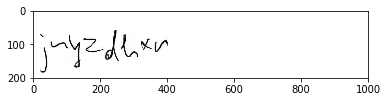

  'jnyzdhxr' -> 'ajjzzjjj<STOP>'
  Batch: 100 Loss: 2.5497260875550523
Test loss: 2.549934
Training epoch 3...
  Batch: 30 Loss: 2.741520755934337
  Batch: 60 Loss: 2.4247013552479015
  Batch: 90 Loss: 2.45954924974492
  Batch: 120 Loss: 2.3714042190269193
  Batch: 150 Loss: 2.4526553943926697
  Batch: 180 Loss: 2.405256700263452
  Batch: 210 Loss: 2.5039255800322886
  Batch: 240 Loss: 2.5341192801541115
  Batch: 270 Loss: 2.604446190992992
  Batch: 300 Loss: 2.6075418379950146
  Batch: 330 Loss: 2.5475719050124837
  Batch: 360 Loss: 2.3905469518616087
  Batch: 390 Loss: 2.5839840573734705
Train loss: 3.254790
Discr applied 0 times.
Testing...
100


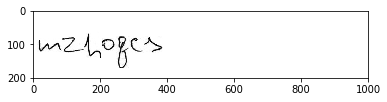

  'mzhoqcs' -> 'vvvvaaa<STOP>'


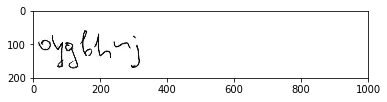

  'oygbhnj' -> 'nvvvaz<STOP><STOP>'


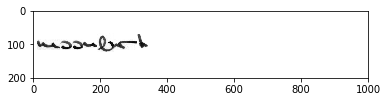

  'mssnbrt' -> 'navvvap<STOP>'
  Batch: 20 Loss: 2.6800373488191576
100


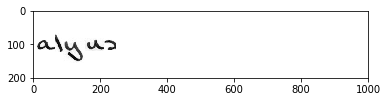

  'alyus' -> 'mdua<STOP><STOP>'


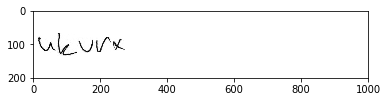

  'ukvrx' -> 'vzvvq<STOP>'


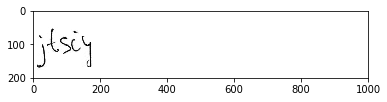

  'jtsiy' -> 'nvvvr<STOP>'
  Batch: 40 Loss: 2.4286841907387684
100


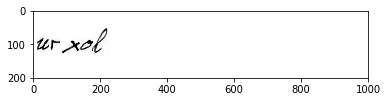

  'urxol' -> 'wvvvv<STOP>'


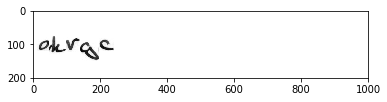

  'okrgc' -> 'dvvvg<STOP>'


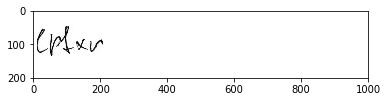

  'lpfxr' -> 'vvvva<STOP>'
  Batch: 60 Loss: 2.4978681270849132
100


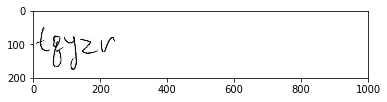

  'tqyzr' -> 'vvvzx<STOP>'


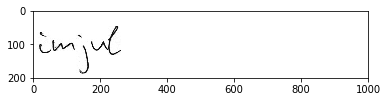

  'imjul' -> 'hvvvu<STOP>'


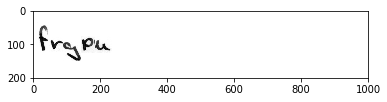

  'frgpk' -> 'dgvga<STOP>'
  Batch: 80 Loss: 2.5431122410486617
100


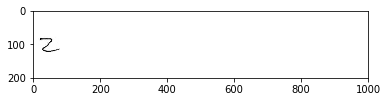

  'z' -> 'z<STOP>'


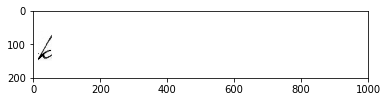

  'k' -> 'k<STOP>'


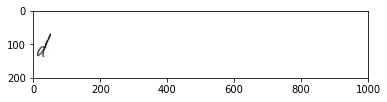

  'd' -> 'z<STOP>'
  Batch: 100 Loss: 2.4261442183123694
Test loss: 2.490267
Training epoch 4...
  Batch: 30 Loss: 2.5371593968073523
  Batch: 60 Loss: 2.4426769995815545
  Batch: 90 Loss: 2.5617639036531794
  Batch: 120 Loss: 2.676752731522555
  Batch: 150 Loss: 2.5400262598512033
  Batch: 180 Loss: 2.5443024120885855
  Batch: 210 Loss: 2.4443800437513477
  Batch: 240 Loss: 2.5050243667193826
  Batch: 270 Loss: 2.5645859983863017
  Batch: 300 Loss: 2.617064158651564
  Batch: 330 Loss: 2.4392452133647984
  Batch: 360 Loss: 2.599060081123675
  Batch: 390 Loss: 2.554332312149976
Train loss: 3.249005
Discr applied 0 times.
Testing...
100


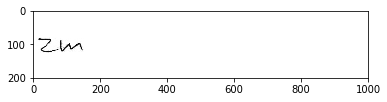

  'zm' -> 'zz<STOP>'


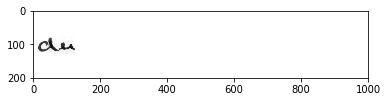

  'dn' -> 'og<STOP>'


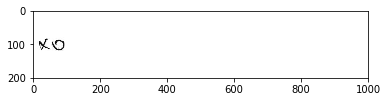

  'xo' -> 'xz<STOP>'
  Batch: 20 Loss: 2.6417108371522686
100


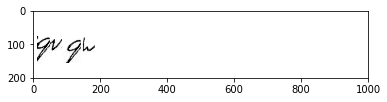

  'qvqw' -> 'wqop<STOP>'


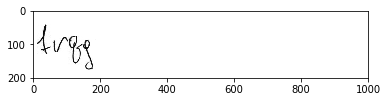

  'frqg' -> 'huoz<STOP>'


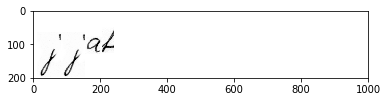

  'jjat' -> 'dhgz<STOP>'
  Batch: 40 Loss: 2.708994627263811
100


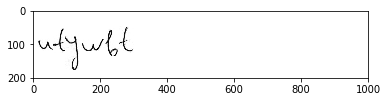

  'utywbt' -> 'ltzooz<STOP>'


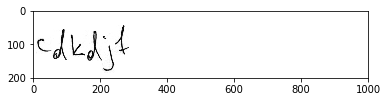

  'cdkdjf' -> 'dozzox<STOP>'


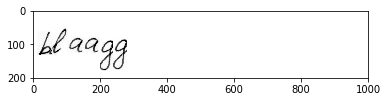

  'blaagg' -> 'lozooe<STOP>'
  Batch: 60 Loss: 2.5961520624160768
100


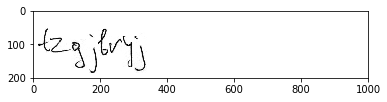

  'tzgjbryj' -> 'dlzzddzl<STOP>'


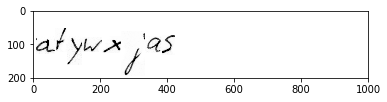

  'atywxjas' -> 'oizzoooz<STOP>'


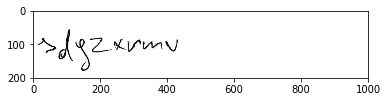

  'sdgzxrmv' -> 'drodzodo<STOP>'
  Batch: 80 Loss: 2.5900081743891272
100


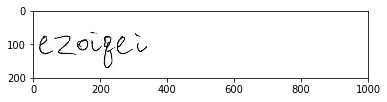

  'ezoiqei' -> 'loooozz<STOP>'


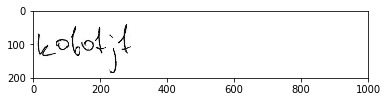

  'kobofjf' -> 'lozbozd<STOP>'


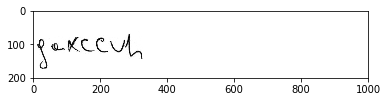

  'gaxccvh' -> 'wrzoozt<STOP>'
  Batch: 100 Loss: 2.320881061497189
Test loss: 2.546088
Training epoch 5...
  Batch: 30 Loss: 2.647794611542312
  Batch: 60 Loss: 2.5645444297159794
  Batch: 90 Loss: 2.6865823236596644
  Batch: 120 Loss: 2.4301398337707316
  Batch: 150 Loss: 2.632024511155627
  Batch: 180 Loss: 2.629203663503051
  Batch: 210 Loss: 2.4142992273335735
  Batch: 240 Loss: 2.5003352913150083
  Batch: 270 Loss: 2.425939232672333
  Batch: 300 Loss: 2.5174489839997864
  Batch: 330 Loss: 2.4836447086914504
  Batch: 360 Loss: 2.5314373989710726
  Batch: 390 Loss: 2.368178845246633
Train loss: 3.258544
Discr applied 0 times.
Testing...
100


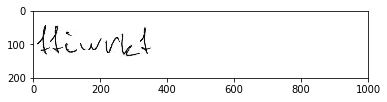

  'ffiwrkf' -> 'ssnnnnn<STOP>'


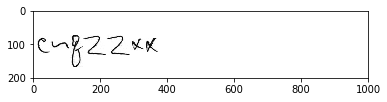

  'cnqzzxx' -> 'wfwwwwi<STOP>'


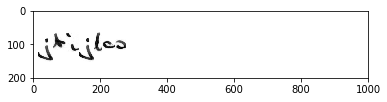

  'jtijlos' -> 'ltpppdp<STOP>'
  Batch: 20 Loss: 2.657569949532312
100


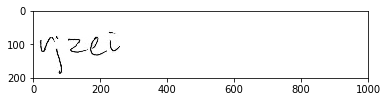

  'rjzei' -> 'npnnx<STOP>'


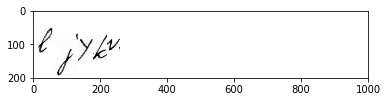

  'ljykv' -> 'ssqnx<STOP>'


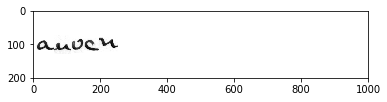

  'anvcu' -> 'lnnnf<STOP>'
  Batch: 40 Loss: 2.521956258009351
100


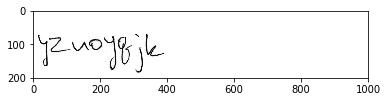

  'yzuoyqjk' -> 'tppkdnnn<STOP>'


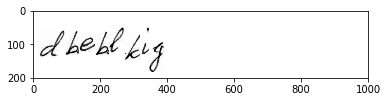

  'dbeblkig' -> 'mwwwwwao<STOP>'


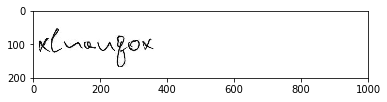

  'xlnauqox' -> 'nnqonnnr<STOP>'
  Batch: 60 Loss: 2.363454436120533
100


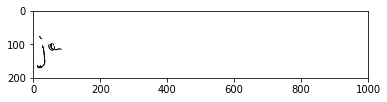

  'ja' -> 'zi<STOP>'


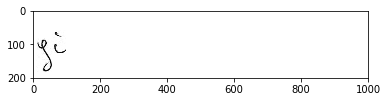

  'gi' -> 'z<STOP><STOP>'


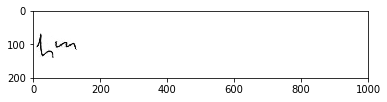

  'hm' -> 'zn<STOP>'
  Batch: 80 Loss: 2.213909204006195
100


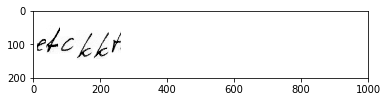

  'etckkt' -> 'lsnonn<STOP>'


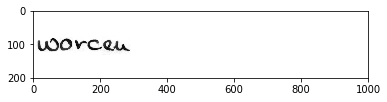

  'worcek' -> 'dnnnnv<STOP>'


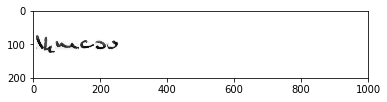

  'lkmcsv' -> 'loopnn<STOP>'
  Batch: 100 Loss: 2.545345961479913
Test loss: 2.436086
Training epoch 6...
  Batch: 30 Loss: 2.490935120431204
  Batch: 60 Loss: 2.5559857929825154
  Batch: 90 Loss: 2.386766517414618
  Batch: 120 Loss: 2.5532972038107578
  Batch: 150 Loss: 2.507580980737374
  Batch: 180 Loss: 2.5147736098274356
  Batch: 210 Loss: 2.579713427074372
  Batch: 240 Loss: 2.5058380789353105
  Batch: 270 Loss: 2.4838785093045104
  Batch: 300 Loss: 2.5586829995982865
  Batch: 330 Loss: 2.5903483181908014
  Batch: 360 Loss: 2.579472297083133
  Batch: 390 Loss: 2.579839867624657
Train loss: 3.229849
Discr applied 0 times.
Testing...
100


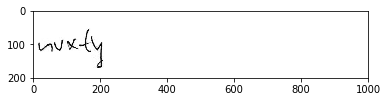

  'nvxty' -> 'mzgg<STOP><STOP>'


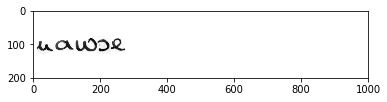

  'kawse' -> 'azzzs<STOP>'


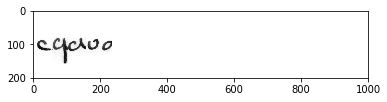

  'cqdvo' -> 'pccbq<STOP>'
  Batch: 20 Loss: 2.7837644868237628
100


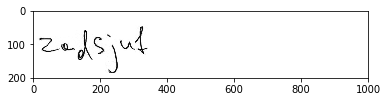

  'zadsjuf' -> 'acagzz<STOP><STOP>'


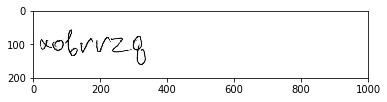

  'xobrrzq' -> 'njawzz<STOP><STOP>'


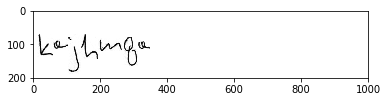

  'kajhmqa' -> 'njzzzm<STOP><STOP>'
  Batch: 40 Loss: 2.666359446332568
100


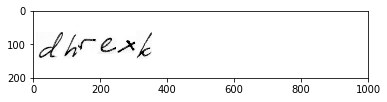

  'dhrexk' -> 'njjzzs<STOP>'


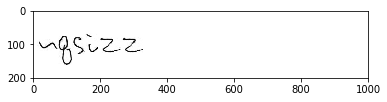

  'nqsizz' -> 'azzzzl<STOP>'


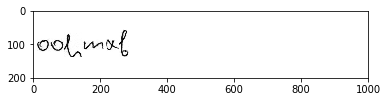

  'oohmxb' -> 'iozzz<STOP><STOP>'
  Batch: 60 Loss: 2.389600489366622
100


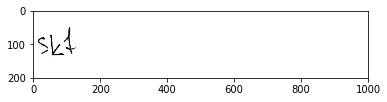

  'skf' -> 'agy<STOP>'


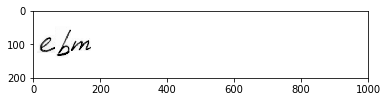

  'ebm' -> 'mjj<STOP>'


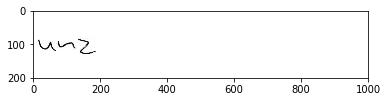

  'unz' -> 'mza<STOP>'
  Batch: 80 Loss: 2.673192965189616
100


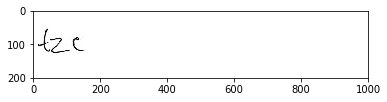

  'tzc' -> 'uzb<STOP>'


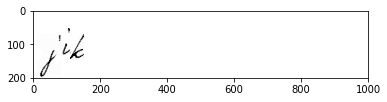

  'jik' -> 'njb<STOP>'


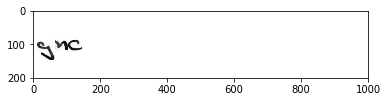

  'gnc' -> 'cgs<STOP>'
  Batch: 100 Loss: 2.683765197481428
Test loss: 2.613204
Training epoch 7...
  Batch: 30 Loss: 2.5408140633976646
  Batch: 60 Loss: 2.2291109679111094
  Batch: 90 Loss: 2.447210707954629
  Batch: 120 Loss: 2.456152361776463
  Batch: 150 Loss: 2.5006247806675215
  Batch: 180 Loss: 2.5374013129617805
  Batch: 210 Loss: 2.3880627444055347
  Batch: 240 Loss: 2.568375629003717
  Batch: 270 Loss: 2.247986350929926
  Batch: 300 Loss: 2.33667749367063
  Batch: 330 Loss: 2.3987467300702656
  Batch: 360 Loss: 2.338770415114347
  Batch: 390 Loss: 2.5631506192621103
Train loss: 3.160791
Discr applied 0 times.
Testing...
100


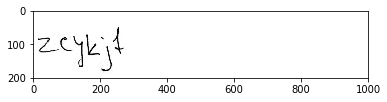

  'zcykjf' -> 'mzzzv<STOP><STOP>'


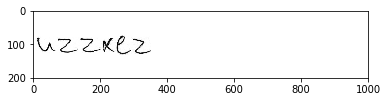

  'uzzxez' -> 'mzzzz<STOP><STOP>'


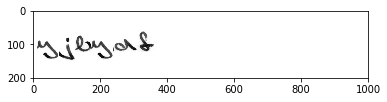

  'yjbydf' -> 'mmvnu<STOP><STOP>'
  Batch: 20 Loss: 2.821376103049233
100


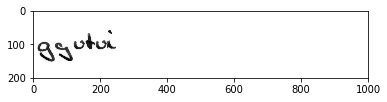

  'ggvtvi' -> 'opvvv<STOP><STOP>'


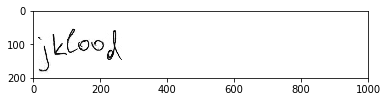

  'jklood' -> 'ivvbq<STOP><STOP>'


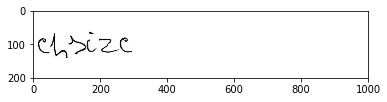

  'chsizc' -> 'zzvzx<STOP><STOP>'
  Batch: 40 Loss: 2.515344343620634
100


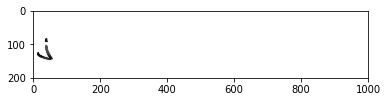

  'j' -> 'j<STOP>'


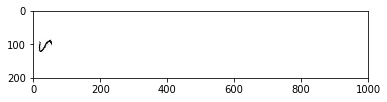

  'r' -> 'k<STOP>'


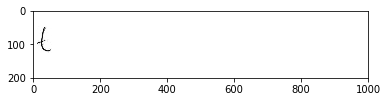

  't' -> 'i<STOP>'
  Batch: 60 Loss: 2.565311979925822
100


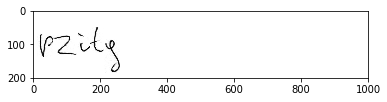

  'pzitg' -> 'zzzav<STOP>'


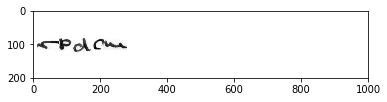

  'rpdcm' -> 'mmzx<STOP><STOP>'


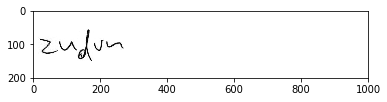

  'zudvn' -> 'zzuz<STOP><STOP>'
  Batch: 80 Loss: 2.683675059023357
100


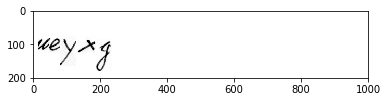

  'ueyxg' -> 'jjjq<STOP><STOP>'


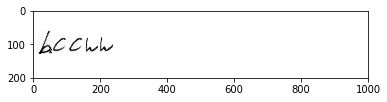

  'bccww' -> 'jjlb<STOP><STOP>'


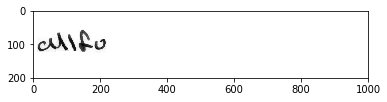

  'dllfv' -> 'pvvlt<STOP>'
  Batch: 100 Loss: 2.3423273504537248
Test loss: 2.560007
Training epoch 8...
  Batch: 30 Loss: 2.5336942681685963
  Batch: 60 Loss: 2.4229800064727747
  Batch: 90 Loss: 2.455056161085765


KeyboardInterrupt: ignored

In [0]:
for i in range(0, 15):
  max_size = 8
  prob = 1
  train(i, max_size, False, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 7):
  max_size = 1
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 10):
  max_size = 3
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  if i %3 == 0:
    state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

    torch.save(state_dict, file_name)
    print("Network saved")
  max_size = 8
  prob = 0.5
  train(i, max_size, False, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  max_size = 6
  train(i, max_size, True)
  test(max_size)

In [0]:
test(1)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [0]:
test(2)

In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))

In [0]:
test(2, 1 )

In [0]:
 def save_net(file_name):
  state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
def restore_net(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
  encoder_optimizer.load_state_dict(state["encoder_optimizer"])
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
save_net("/gdrive/My Drive/unif_8_6.tar")

Network saved: /gdrive/My Drive/unif_8_6.tar
